Проведение разведывательного анализа влияния условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике для формирования модели предсказания результата экзамена для каждого ученика.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import scipy
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 35) 
pd.set_option('display.max_columns', None)
stud = pd.read_csv('stud_math.xls')

In [2]:
'''Функция очистки столбцов от пропусков'''


def first_none(column, dframe=None):
    if dframe is None:
        dframe = stud
    dframe[column] = dframe[column].apply(lambda x: None if pd.isna(x)
                                          else None if str(x).strip() == '' else x)


'''Функция показа столбцов с / без NaN(None). Пустой параметр - столбцы с NaN(None), 
любой другой - без'''


def columns_none(word=None, dframe=None):
    if dframe is None:
        dframe = stud
    stud_list = [dframe[column].hasnans for column in dframe.columns]
    if word == None:
        return dframe[dframe.columns[stud_list]]
    else:
        return dframe[dframe.columns[[False if x else True for x in stud_list]]]


'''Функция показа числовых / не числовых столбцов. Пустой параметр - числовые столбцы, 
'o' - не числовые'''


def columns_type(column_type=None, dframe=None):
    if dframe is None:
        dframe = stud
    if column_type == 'o':
        return dframe.select_dtypes(exclude='number')
    else:
        return dframe.select_dtypes(include='number')


'''Функция замены значения в столбце'''


def change_column(column, old_value, new_value, dframe=None):
    if dframe is None:
        dframe = stud
    dframe[column] = dframe[column].apply(lambda x: new_value if pd.isna(old_value) and pd.isna(x)
                                          else new_value if x == old_value else x)


'''Функция получения статистических данных по столбцу'''


def stats(column, dframe=None):
    if dframe is None:
        dframe = stud
    if dframe[column].dtypes in ['int64', 'float64']:
        perc25 = dframe[column].quantile(0.25)
        column_median = dframe[column].median()
        column_mean = round(dframe[column].mean(), 4)
        perc75 = dframe[column].quantile(0.75)
        IQR = dframe[column].quantile(0.75) - dframe[column].quantile(0.25)
        IQR_val = dframe[column].loc[dframe[column].between(perc25, perc75)].count()
        IQR_val_percent = round(IQR_val/(dframe[column].count())*100, 2)
        min_point = perc25 - 1.5*IQR
        max_point = perc75 + 1.5*IQR
        stats_range = dframe[column].loc[dframe[column].between(min_point, max_point)].count()
        stats_range_percent = round(stats_range/(dframe[column].count())*100, 2)
        print('Показатели для -= {} =-:'.format(column), '\n', '\n',
              'Общее количество значений (non-NA/null значений): {} ({})'.format(dframe.shape[0],
                                                                                 dframe[column].count()), '\n',
              'Уникальные значения: {}'.format(
                  list(sorted(dframe[column].unique()))), '\n',
              'Минимум: {}'.format(min(dframe[column])), '\n',
              'Максимум: {}'.format(max(dframe[column])), '\n',
              'Мода: {}'.format(list(dframe[column].mode(dropna=False))), '\n',
              'Медиана: {}'.format(column_median), '\n',
              'Среднее: {}'.format(column_mean), '\n',
              'STD: {}'.format(round(dframe[column].std(), 4)), '\n',
              '25-й перцентиль: {}'.format(perc25), '\n',
              '75-й перцентиль: {}'.format(perc75), '\n',
              'IQR: {0}, кол-во значений: {1}, {2}%'.format(
                  IQR, IQR_val, IQR_val_percent), '\n',
              'Границы выбросов: [{0}, {1}], кол-во значений: {2}, {3}%'.format(min_point, max_point,
                                                                                 stats_range,
                                                                                 stats_range_percent), '\n',
              'Выбросы слева: {}, количество выбросов: {}'
              .format(list(sorted(dframe[column][dframe[column] < min_point])),
                      len(list(dframe[column][dframe[column] < min_point]))), '\n',
              'Выбросы справа: {}, количество выбросов: {}'
              .format(list(sorted(dframe[column][dframe[column] > max_point])),
                      len(list(dframe[column][dframe[column] > max_point]))), sep='')
        pd_object = pd.merge(dframe[column].value_counts(dropna=False).reset_index(),
                             (dframe[column].value_counts(normalize=True, dropna=False)*100)
                             .reset_index(), on='index')
        pd_object.columns = ['values', 'counts', '%']
        display(pd.DataFrame(pd_object))
        # dframe[column].hist()
        sns.set_theme(style="whitegrid")
        sns.displot(x=column, bins=50, kde=True, data=dframe)
        # if stud[column].hasnans == False:
        fig = plt.figure()
        ax = fig.add_axes([0, 0, 1, 0.25])
        # ax1.boxplot(dframe[column][dframe[column].isna() == False],
        #            vert=False,flierprops=dict(markerfacecolor='r', marker='D'))
        sns.boxplot(x=column, data=dframe, ax=ax)
    else:
        print('Показатели для -= {} =-:'.format(column))
        display(pd.DataFrame(dframe[column].describe(include=all)))
        pd_object = pd.merge(dframe[column].value_counts(dropna=False).reset_index(),
                             (dframe[column].value_counts(normalize=True, dropna=False)*100)
                             .reset_index(), on='index')
        pd_object.columns = ['values', 'counts', '%']
        display(pd.DataFrame(pd_object))
        #dframe[column].value_counts().plot(kind = 'bar', grid = True)
        x_column = dframe[column][dframe[column].isna() == False]
        sns.set_theme(style="whitegrid")
        sns.histplot(x=x_column, bins=100, shrink=.4, data=dframe)


'''Показ боксплота'''


def get_boxplot(column_x, column_y, dframe=None):
    if dframe is None:
        dframe = stud
    #fig, ax = plt.subplots(figsize = (10, 4))
    fig, ax = plt.subplots(figsize=((dframe[column_x].nunique())*1.5, 4))
    sns.boxplot(x=column_x, y=column_y, data=dframe)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column_x)
    plt.show()


'''Функция замены показателей на значения из периодов, соответствующих показателям'''


def values_minutes(column, old_value, start_minutes, end_minutes, number, dframe=None):
    if dframe is None:
        dframe = stud
    i = 0
    row_index_list = dframe[dframe[column] == old_value].index
    np.random.seed(1)
    random_list = np.random.randint(start_minutes, end_minutes, number)
    for row_index in row_index_list:
        dframe.iat[row_index, list(dframe.columns).index(column)] = random_list[i]
        i += 1


'''Тест Стьюдента'''


def get_stat_dif(column, column2, dframe=None):
    if dframe is None:
        dframe = stud
    cols = dframe.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        stat, p = ttest_ind(dframe.loc[dframe.loc[:, column] == comb[0], column2],
                            dframe.loc[dframe.loc[:, column] == comb[1], column2])
       # print(comb)
       # print('Statistics=%.3f, p-value=%.3f' % (stat, p))
        if p <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки',
                  column, 'p-value=', round(p, 4))
            return column


'''Функция пропорциональной замены nan'''


def nan_to_values(column, step, value1, value2, dframe=None):
    if dframe is None:
        dframe = stud
    nan_index_list = dframe[pd.isna(dframe[column])].index
    for index in nan_index_list[::step]:
        dframe.iat[index, dframe.columns.get_loc(column)] = value1
    change_column(column, None, value2, dframe=None)


'''Тепловая карта'''


def heat_map(dframe=None):
    if dframe is None:
        dframe = stud
    plt.figure(figsize=(10, 5))
    sns.heatmap(dframe.corr(), cmap="BrBG", annot=True)
    score_corr = dframe.corr()['score'][:-1]
    print('Количество характеристик:', score_corr.shape[0])
    display(score_corr)
    print('Максимальный коэффициент:',
          score_corr[score_corr.abs() == score_corr.abs().max()], '\n')
    print('Минимальный коэффициент:',
          score_corr[score_corr.abs() == score_corr.abs().min()])


'''Взаимосвязь одного из значений в столбце со значениями score'''


def rel_score(column, dframe=None):
    if dframe is None:
        dframe = stud
    dframe = dframe[dframe[column].isna() == False]
    for value in sorted(dframe[column].unique()):
        if dframe[dframe[column] == value].score.nunique() > 1:
            # sns.displot(x='score',data=dframe[dframe[column]==value],col=column,kde='reg')
            print(value)
            sns.histplot(data=dframe[dframe[column] == value], x='score', bins=50, kde=True)
            plt.show()
        else:
            print(value)
            sns.histplot(data=dframe[dframe[column] == value], x='score', bins=50)
            plt.show()


'''Cвязь между score и номинативными характеристиками'''


def score_nominative(dframe=None):
    if dframe is None:
        dframe = stud
    stat_dif = []
    for column in columns_type('o', dframe).columns:
        temp = get_stat_dif(column, 'score', dframe)
        if temp is not None:
            stat_dif.append(temp)
    for column in stat_dif:
        print('\n', 'Графики для', column)
        get_boxplot(column, 'score', dframe)
        rel_score(column, dframe)

In [3]:
# можно и stud.info()
print('Всего NaN:',stud.isna().sum().sum())
display(pd.DataFrame([stud.dtypes, stud.count(), stud.nunique(), stud.isna().sum()],
                     index=['dtype', 'count', 'unic values', 'NaN', ]).T)

Всего NaN: 565


,dtype,count,unic values,NaN
school,object,395,2,0
sex,object,395,2,0
age,int64,395,8,0
address,object,378,2,17
famsize,object,368,2,27
Pstatus,object,350,2,45
Medu,float64,392,5,3
Fedu,float64,371,6,24
Mjob,object,376,5,19
Fjob,object,359,5,36


Посмотрим на исследуемую характеристику - score

In [4]:
# Заменим отсутствующие значения на None
for column in stud.columns:
    first_none(column)

Показатели для -= score =-:

Общее количество значений (non-NA/null значений): 395 (389)
Уникальные значения: [0.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, nan]
Минимум: 0.0
Максимум: 100.0
Мода: [50.0]
Медиана: 55.0
Среднее: 52.2622
STD: 22.919
25-й перцентиль: 40.0
75-й перцентиль: 70.0
IQR: 30.0, кол-во значений: 247, 63.5%
Границы выбросов: [-5.0, 115.0], кол-во значений: 389, 100.0%
Выбросы слева: [], количество выбросов: 0
Выбросы справа: [], количество выбросов: 0


,values,counts,%
0,50.0,54,13.670886
1,55.0,46,11.645570
2,0.0,37,9.367089
3,75.0,33,8.354430
4,65.0,31,7.848101
5,40.0,31,7.848101
6,60.0,31,7.848101
7,45.0,27,6.835443
8,70.0,27,6.835443
9,80.0,16,4.050633


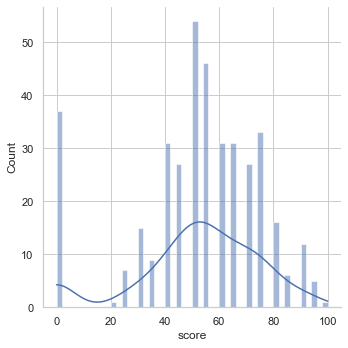

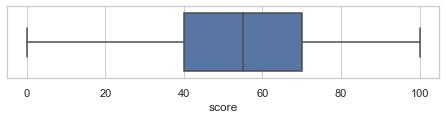

In [5]:
stats('score')

Score исследуемая характеристика, которая, как предполагается находится в зависимости от других 29 характеристик. Связь между ними является предметом исследования и чтобы не вносить искажение, откажемся от замены nan на какой-либо показатель. Удалим nan, сохранив в отдельном сете.

Показатели для -= score =-:

Общее количество значений (non-NA/null значений): 389 (389)
Уникальные значения: [0.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0]
Минимум: 0.0
Максимум: 100.0
Мода: [50.0]
Медиана: 55.0
Среднее: 52.2622
STD: 22.919
25-й перцентиль: 40.0
75-й перцентиль: 70.0
IQR: 30.0, кол-во значений: 247, 63.5%
Границы выбросов: [-5.0, 115.0], кол-во значений: 389, 100.0%
Выбросы слева: [], количество выбросов: 0
Выбросы справа: [], количество выбросов: 0


,values,counts,%
0,50.0,54,13.881748
1,55.0,46,11.825193
2,0.0,37,9.511568
3,75.0,33,8.483290
4,65.0,31,7.969152
5,40.0,31,7.969152
6,60.0,31,7.969152
7,70.0,27,6.940874
8,45.0,27,6.940874
9,80.0,16,4.113111


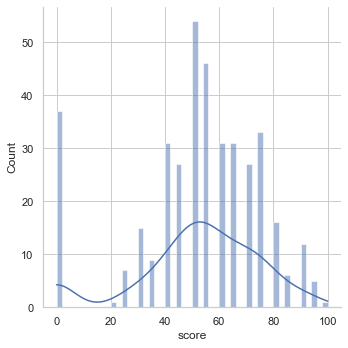

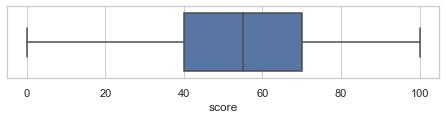

In [6]:
stud_score_nan = stud[stud['score'].isna()]
stud.drop(stud[stud['score'].isna()].index, inplace=True)
stud.reset_index(drop=True, inplace=True)
stats('score')

Посмотрим корреляцию исходных данных, связь между score и числовыми характеристиками

Количество характеристик: 12


age                   -0.155726
Medu                   0.213349
Fedu                   0.078573
traveltime            -0.070559
studytime              0.115741
failures              -0.344338
studytime, granular   -0.115741
famrel                 0.057112
freetime               0.019026
goout                 -0.129685
health                -0.070460
absences               0.065283
Name: score, dtype: float64

Максимальный коэффициент: failures   -0.344338
Name: score, dtype: float64 

Минимальный коэффициент: freetime    0.019026
Name: score, dtype: float64


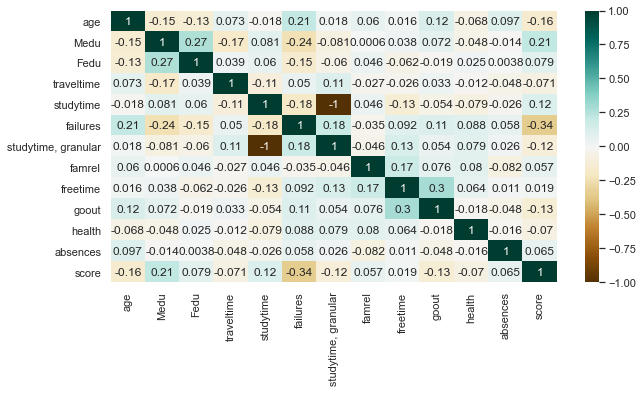

In [7]:
heat_map()

У 'studytime' и 'studytime, granular' коэффициент '-1'. Учитывая, что у studytime, granular отсутствует описание - удалим этот столбец.

In [8]:
stud = stud.drop(['studytime, granular'], axis=1)

Посмотрим связь между score и номинативными характеристиками

Найдены статистически значимые различия для колонки address p-value= 0.0202
Найдены статистически значимые различия для колонки Mjob p-value= 0.0042
Найдены статистически значимые различия для колонки higher p-value= 0.0003
Найдены статистически значимые различия для колонки romantic p-value= 0.0074

 Графики для address


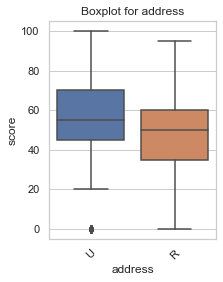

R


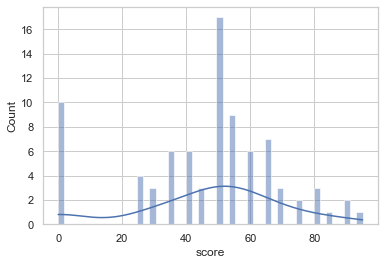

U


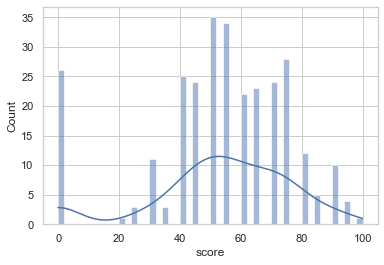


 Графики для Mjob


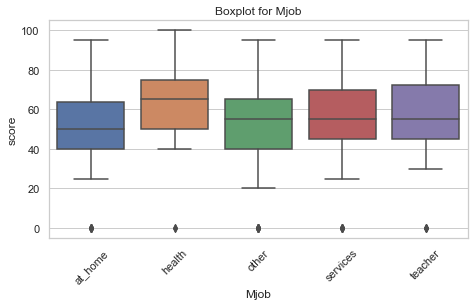

at_home


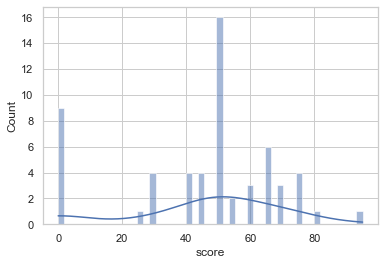

health


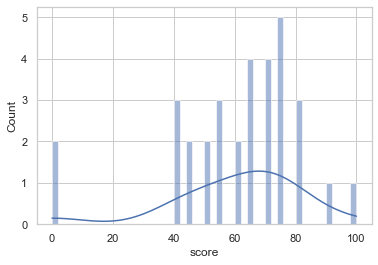

other


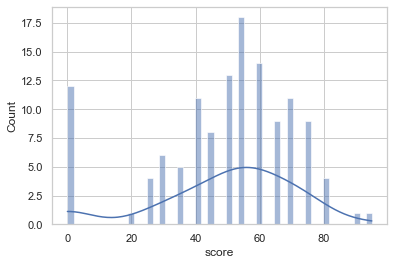

services


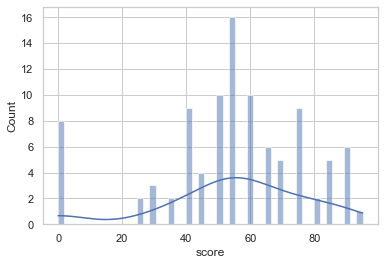

teacher


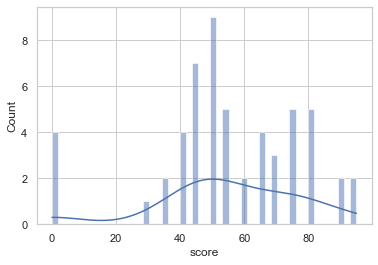


 Графики для higher


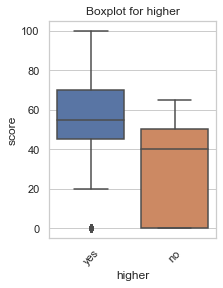

no


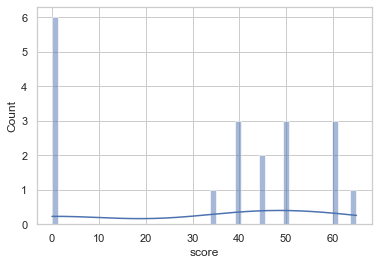

yes


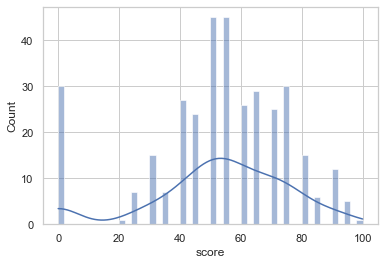


 Графики для romantic


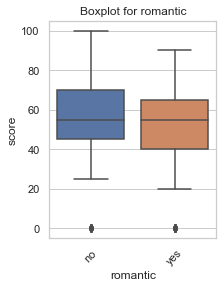

no


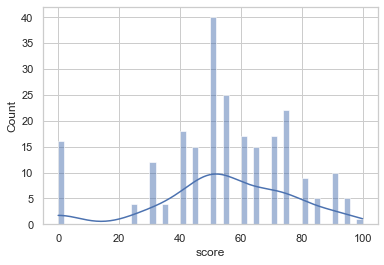

yes


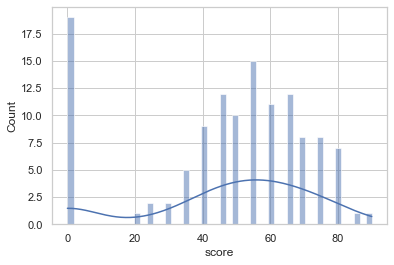

In [9]:
score_nominative()

На данном этапе видим, что с чиcловыми признаками у score слабая корреляция, среди номинативных имеется пока 4 признака, оказывающие влияние.

Посмотрим на столбцы, где отсутствуют пропуски значений.

In [10]:
columns_none(1).head(10)

,school,sex,age,score
0,GP,F,18,30.0
1,GP,F,17,30.0
2,GP,F,15,50.0
3,GP,F,15,75.0
4,GP,F,16,50.0
5,GP,M,16,75.0
6,GP,M,16,55.0
7,GP,F,17,30.0
8,GP,M,15,95.0
9,GP,M,15,75.0


Показатели для -= school =-:


,school
count,389
unique,2
top,GP
freq,344


,values,counts,%
0,GP,344,88.431877
1,MS,45,11.568123


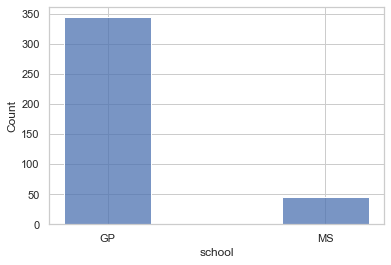

In [11]:
stats('school')

Большая часть учеников сосредоточена в одной школе.

Показатели для -= sex =-:


,sex
count,389
unique,2
top,F
freq,204


,values,counts,%
0,F,204,52.442159
1,M,185,47.557841


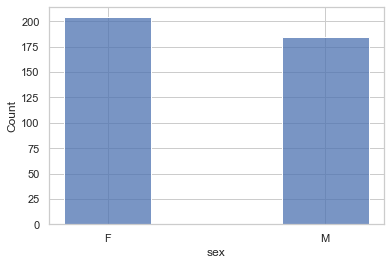

In [12]:
stats('sex')

Распределение по гендерному признаку примерно одинаково.

Показатели для -= age =-:

Общее количество значений (non-NA/null значений): 389 (389)
Уникальные значения: [15, 16, 17, 18, 19, 20, 21, 22]
Минимум: 15
Максимум: 22
Мода: [16]
Медиана: 17.0
Среднее: 16.6735
STD: 1.2657
25-й перцентиль: 16.0
75-й перцентиль: 18.0
IQR: 2.0, кол-во значений: 281, 72.24%
Границы выбросов: [13.0, 21.0], кол-во значений: 388, 99.74%
Выбросы слева: [], количество выбросов: 0
Выбросы справа: [22], количество выбросов: 1


,values,counts,%
0,16,103,26.478149
1,17,98,25.192802
2,15,82,21.079692
3,18,80,20.565553
4,19,21,5.398458
5,20,3,0.771208
6,22,1,0.257069
7,21,1,0.257069


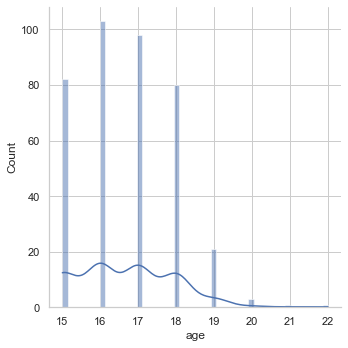

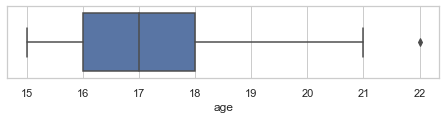

In [13]:
stats('age')

Возраст является собственной, неотъемлемой характеристикой студента. Несмотря на выбросы и незначительность(~6.5% от учащихся) оставим группу 19+

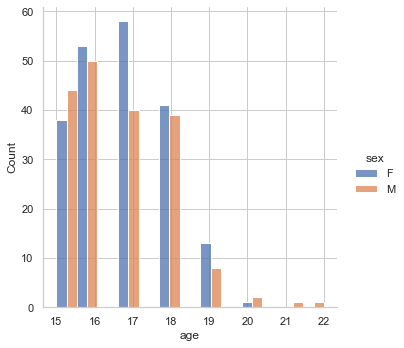

In [14]:
sns.displot(x='age',hue='sex', multiple='dodge', data=stud)

Посмотрим на числовые данные

In [15]:
columns_type().head(10)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
0,18,4.0,4.0,2.0,2.0,0.0,4.0,3.0,4.0,3.0,6.0,30.0
1,17,1.0,1.0,1.0,2.0,0.0,5.0,3.0,3.0,3.0,4.0,30.0
2,15,1.0,1.0,1.0,2.0,3.0,4.0,3.0,2.0,3.0,10.0,50.0
3,15,4.0,2.0,1.0,3.0,0.0,3.0,2.0,2.0,5.0,2.0,75.0
4,16,3.0,3.0,1.0,2.0,0.0,4.0,3.0,2.0,5.0,4.0,50.0
5,16,4.0,3.0,1.0,2.0,0.0,5.0,4.0,2.0,5.0,10.0,75.0
6,16,2.0,2.0,1.0,2.0,0.0,4.0,4.0,4.0,3.0,0.0,55.0
7,17,4.0,4.0,2.0,2.0,0.0,4.0,1.0,4.0,1.0,6.0,30.0
8,15,3.0,2.0,1.0,2.0,0.0,NaN,2.0,2.0,1.0,0.0,95.0
9,15,3.0,4.0,1.0,2.0,0.0,5.0,5.0,1.0,5.0,0.0,75.0


Показатели для -= Medu =-:

Общее количество значений (non-NA/null значений): 389 (386)
Уникальные значения: [0.0, 1.0, 2.0, 3.0, 4.0, nan]
Минимум: 0.0
Максимум: 4.0
Мода: [4.0]
Медиана: 3.0
Среднее: 2.7668
STD: 1.0943
25-й перцентиль: 2.0
75-й перцентиль: 4.0
IQR: 2.0, кол-во значений: 327, 84.72%
Границы выбросов: [-1.0, 7.0], кол-во значений: 386, 100.0%
Выбросы слева: [], количество выбросов: 0
Выбросы справа: [], количество выбросов: 0


,values,counts,%
0,4.0,131,33.676093
1,2.0,100,25.706941
2,3.0,96,24.678663
3,1.0,56,14.395887
4,0.0,3,0.771208
5,NaN,3,0.771208


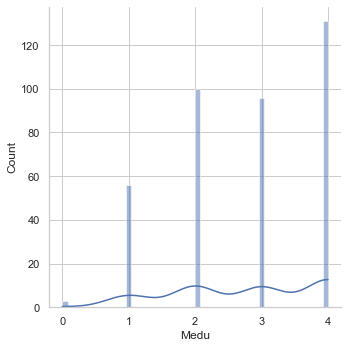

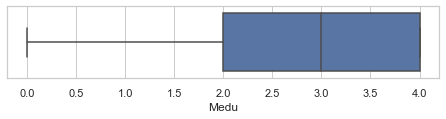

In [16]:
stats('Medu')

Заменим nan на медиану, и, учитывая, что столбец фактически содержит номинативные данные, произведем соответствующую замену. Отсутствие образования у родителя может негативно сказываться на получение образования ребенком и, соответственно, на получаемые оценки. Поэтому, несмотря на незначительный процент в выборке, оставим данное значение характеристики.

Показатели для -= Medu =-:


,Medu
count,389
unique,5
top,высшее
freq,131


,values,counts,%
0,высшее,131,33.676093
1,5-9 классы,100,25.706941
2,сред.спец / 11 классов,99,25.449871
3,4 класса,56,14.395887
4,нет,3,0.771208


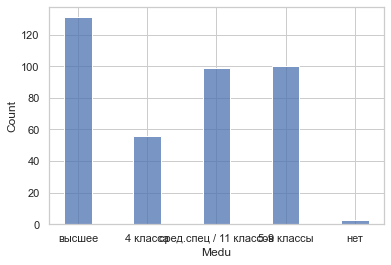

In [17]:
change_column('Medu', None, stud['Medu'].median())
#stud.drop(stud[stud['Medu']==0].index, inplace=True)
#stud.reset_index(drop=True, inplace=True)
change_column('Medu', 0, 'нет')
change_column('Medu', 1, '4 класса')
change_column('Medu', 2, '5-9 классы')
change_column('Medu', 3, 'сред.спец / 11 классов')
change_column('Medu', 4, 'высшее')
stats('Medu')

Показатели для -= Fedu =-:

Общее количество значений (non-NA/null значений): 389 (365)
Уникальные значения: [0.0, 1.0, 2.0, 3.0, 4.0, 40.0, nan]
Минимум: 0.0
Максимум: 40.0
Мода: [2.0]
Медиана: 3.0
Среднее: 2.6274
STD: 2.2418
25-й перцентиль: 2.0
75-й перцентиль: 3.0
IQR: 1.0, кол-во значений: 199, 54.52%
Границы выбросов: [0.5, 4.5], кол-во значений: 362, 99.18%
Выбросы слева: [0.0, 0.0], количество выбросов: 2
Выбросы справа: [40.0], количество выбросов: 1


,values,counts,%
0,2.0,105,26.992288
1,3.0,94,24.164524
2,4.0,88,22.622108
3,1.0,75,19.280206
4,NaN,24,6.169666
5,0.0,2,0.514139
6,40.0,1,0.257069


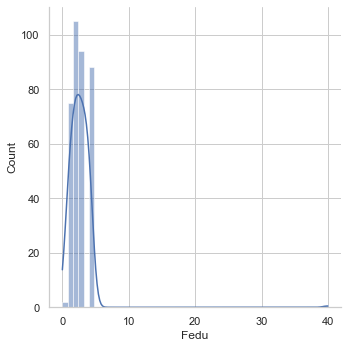

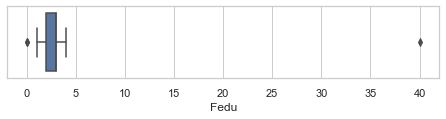

In [18]:
stats('Fedu')

Заменим 40 на 4 и nan на медиану и, учитывая, что столбец фактически содержит номинативные данные, произведем соответствующую замену. Отсутствие образования у родителя может негативно сказываться на получение образования ребенком и, соответственно, на получаемые оценки. Поэтому, несмотря на незначительный процент в выборке, оставим данное значение характеристики.

Показатели для -= Fedu =-:


,Fedu
count,389
unique,5
top,сред.спец / 11 классов
freq,118


,values,counts,%
0,сред.спец / 11 классов,118,30.334190
1,5-9 классы,105,26.992288
2,высшее,89,22.879177
3,4 класса,75,19.280206
4,нет,2,0.514139


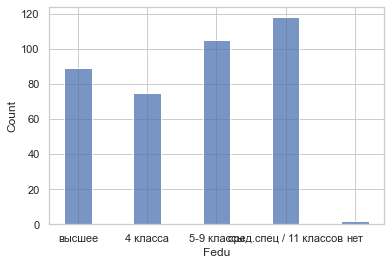

In [19]:
change_column('Fedu', None, stud['Fedu'].median())
change_column('Fedu', 40, 4)
#stud.drop(stud[stud['Fedu']==0].index, inplace=True)
#stud.reset_index(drop=True, inplace=True)
change_column('Fedu', 0, 'нет')
change_column('Fedu', 1, '4 класса')
change_column('Fedu', 2, '5-9 классы')
change_column('Fedu', 3, 'сред.спец / 11 классов')
change_column('Fedu', 4, 'высшее')
stats('Fedu')

Показатели для -= traveltime =-:

Общее количество значений (non-NA/null значений): 389 (361)
Уникальные значения: [1.0, 2.0, 3.0, nan, 4.0]
Минимум: 1.0
Максимум: 4.0
Мода: [1.0]
Медиана: 1.0
Среднее: 1.4349
STD: 0.6927
25-й перцентиль: 1.0
75-й перцентиль: 2.0
IQR: 1.0, кол-во значений: 333, 92.24%
Границы выбросов: [-0.5, 3.5], кол-во значений: 354, 98.06%
Выбросы слева: [], количество выбросов: 0
Выбросы справа: [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0], количество выбросов: 7


,values,counts,%
0,1.0,239,61.439589
1,2.0,94,24.164524
2,NaN,28,7.197943
3,3.0,21,5.398458
4,4.0,7,1.799486


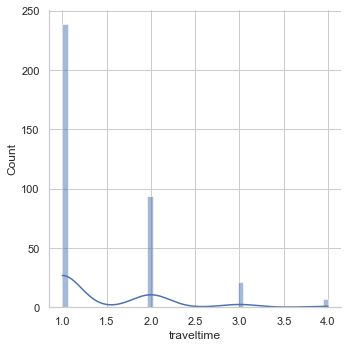

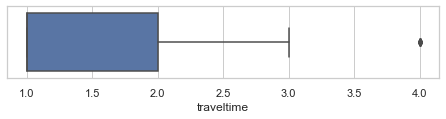

In [20]:
stats('traveltime')

Время, затрачиваемое на путь до школы (traveltime), должно оказывать (и наоборот) влияние на выбор школы (reason) по причине её близкого расположения к дому (home). Заменим nan на медиану, в строках, где есть home. Оставшиеся nan заменим на наиболее частые показатели '1' и '2' в примерном соотношении 3:1.

Показатели для -= traveltime =-:

Общее количество значений (non-NA/null значений): 389 (389)
Уникальные значения: [1.0, 2.0, 3.0, 4.0]
Минимум: 1.0
Максимум: 4.0
Мода: [1.0]
Медиана: 1.0
Среднее: 1.419
STD: 0.6786
25-й перцентиль: 1.0
75-й перцентиль: 2.0
IQR: 1.0, кол-во значений: 361, 92.8%
Границы выбросов: [-0.5, 3.5], кол-во значений: 382, 98.2%
Выбросы слева: [], количество выбросов: 0
Выбросы справа: [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0], количество выбросов: 7


,values,counts,%
0,1.0,261,67.095116
1,2.0,100,25.706941
2,3.0,21,5.398458
3,4.0,7,1.799486


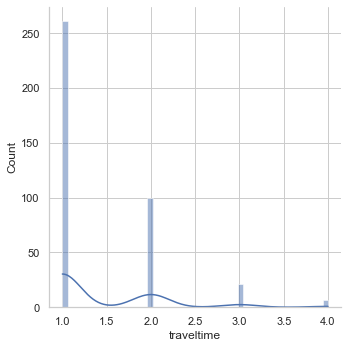

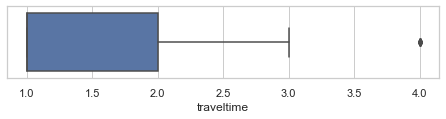

In [21]:
stud['traveltime'] = stud[['reason','traveltime']].apply(lambda x: stud['traveltime'].median()
                                                         if x[0] == 'home' and pd.isna(x[1]) else x[1], 
                                                         axis=1)
nan_to_values ('traveltime',4,2,1)
stats('traveltime')

Учитывая, что значения в данном столбце обозначают временные интервалы, заменим обозначения на значения из интервалов

Показатели для -= traveltime =-:

Общее количество значений (non-NA/null значений): 389 (389)
Уникальные значения: [5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 31.0, 32.0, 36.0, 37.0, 38.0, 39.0, 40.0, 42.0, 43.0, 44.0, 46.0, 47.0, 49.0, 51.0, 56.0, 59.0, 66.0, 69.0, 70.0, 72.0, 73.0]
Минимум: 5.0
Максимум: 73.0
Мода: [12.0]
Медиана: 11.0
Среднее: 15.2956
STD: 12.0065
25-й перцентиль: 8.0
75-й перцентиль: 19.0
IQR: 11.0, кол-во значений: 205, 52.7%
Границы выбросов: [-8.5, 35.5], кол-во значений: 363, 93.32%
Выбросы слева: [], количество выбросов: 0
Выбросы справа: [36.0, 36.0, 36.0, 37.0, 38.0, 39.0, 40.0, 42.0, 42.0, 43.0, 43.0, 44.0, 46.0, 47.0, 49.0, 49.0, 51.0, 56.0, 59.0, 66.0, 66.0, 69.0, 70.0, 72.0, 72.0, 73.0], количество выбросов: 26


,values,counts,%
0,12.0,39,10.025707
1,5.0,35,8.997429
2,9.0,29,7.455013
3,11.0,28,7.197943
4,7.0,27,6.940874
...,...,...,...
40,46.0,1,0.257069
41,73.0,1,0.257069
42,40.0,1,0.257069
43,39.0,1,0.257069


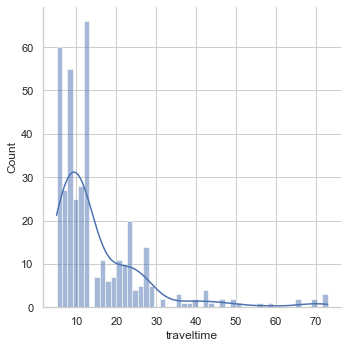

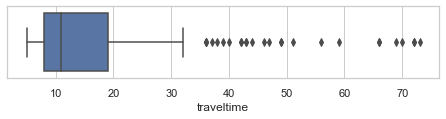

In [22]:
#stud.drop(stud[stud['traveltime']==4].index, inplace=True)
#stud.reset_index(drop=True, inplace=True)
values_minutes('traveltime',1,5,14,261)
values_minutes('traveltime',2,15,30,100)
values_minutes('traveltime',3,31,60,21)
values_minutes('traveltime',4,61,90,7)
stats('traveltime')

Время в пути до школы в пределах 1 часа 15 минут, оставим пока выбросы

Показатели для -= studytime =-:

Общее количество значений (non-NA/null значений): 389 (382)
Уникальные значения: [1.0, 2.0, 3.0, nan, 4.0]
Минимум: 1.0
Максимум: 4.0
Мода: [2.0]
Медиана: 2.0
Среднее: 2.0366
STD: 0.8472
25-й перцентиль: 1.0
75-й перцентиль: 2.0
IQR: 1.0, кол-во значений: 292, 76.44%
Границы выбросов: [-0.5, 3.5], кол-во значений: 355, 92.93%
Выбросы слева: [], количество выбросов: 0
Выбросы справа: [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0], количество выбросов: 27


,values,counts,%
0,2.0,189,48.586118
1,1.0,103,26.478149
2,3.0,63,16.195373
3,4.0,27,6.940874
4,NaN,7,1.799486


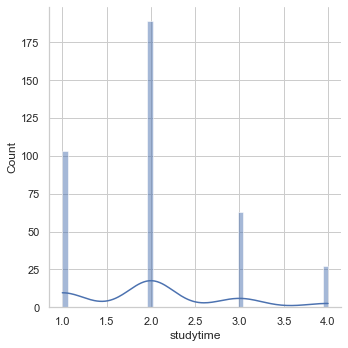

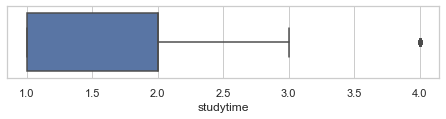

In [23]:
stats('studytime')

Заменим nan на медиану

Показатели для -= studytime =-:

Общее количество значений (non-NA/null значений): 389 (389)
Уникальные значения: [1.0, 2.0, 3.0, 4.0]
Минимум: 1.0
Максимум: 4.0
Мода: [2.0]
Медиана: 2.0
Среднее: 2.036
STD: 0.8396
25-й перцентиль: 1.0
75-й перцентиль: 2.0
IQR: 1.0, кол-во значений: 299, 76.86%
Границы выбросов: [-0.5, 3.5], кол-во значений: 362, 93.06%
Выбросы слева: [], количество выбросов: 0
Выбросы справа: [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0], количество выбросов: 27


,values,counts,%
0,2.0,196,50.385604
1,1.0,103,26.478149
2,3.0,63,16.195373
3,4.0,27,6.940874


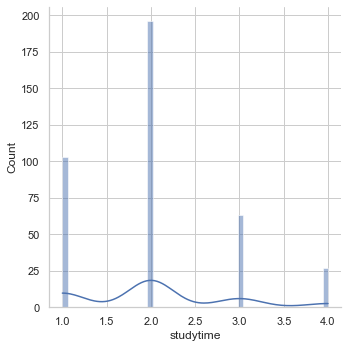

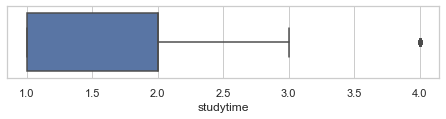

In [24]:
change_column('studytime', None, stud['studytime'].median())
stats('studytime')

Учитывая, что значения в данном столбце обозначают временные интервалы, заменим обозначения на значения из интервалов

Показатели для -= studytime =-:

Общее количество значений (non-NA/null значений): 389 (389)
Уникальные значения: [30.0, 31.0, 32.0, 33.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 48.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 62.0, 64.0, 67.0, 68.0, 71.0, 73.0, 76.0, 77.0, 79.0, 80.0, 82.0, 85.0, 87.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 97.0, 98.0, 100.0, 101.0, 102.0, 104.0, 105.0, 106.0, 107.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 122.0, 123.0, 124.0, 127.0, 128.0, 129.0, 130.0, 131.0, 134.0, 136.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 149.0, 151.0, 152.0, 153.0, 154.0, 156.0, 157.0, 158.0, 161.0, 162.0, 164.0, 166.0, 167.0, 168.0, 169.0, 170.0, 171.0, 173.0, 174.0, 175.0, 176.0, 177.0, 178.0, 181.0, 182.0, 184.0, 185.0, 186.0, 187.0, 189.0, 190.0, 192.0, 193.0, 195.0, 196.0, 197.0, 198.0, 200.0, 201.0, 202.0, 203.0, 204.0, 205.0, 207.0, 208.0, 213.0, 215.0, 217.0, 218.0, 219.0, 221

,values,counts,%
0,217.0,5,1.285347
1,117.0,4,1.028278
2,262.0,4,1.028278
3,131.0,4,1.028278
4,178.0,4,1.028278
...,...,...,...
265,174.0,1,0.257069
266,344.0,1,0.257069
267,608.0,1,0.257069
268,40.0,1,0.257069


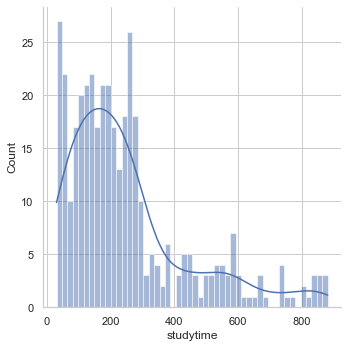

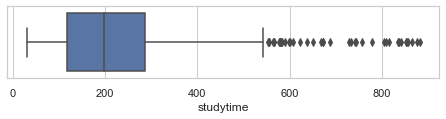

In [25]:
values_minutes('studytime', 1, 30, 120, 103)
values_minutes('studytime', 2, 121, 300, 196)
values_minutes('studytime', 3, 301, 600, 63)
values_minutes('studytime', 4, 601, 900, 27)
stats('studytime')

Рассмотрим вариант с отбрасыванием значений выше верхней границы выброса. Учитывая, что значительных изменений в корреляции со score оставшихся значений нет, а группа значений правее верхней границы выброса имеет отрицательный коэффициент корреляции (хотя увеличение времени дополнительных занятий должно было бы привести к увеличению баллов на экзамене, а не наоборот), оставим выбросы.

In [26]:
#sns.jointplot(x='studytime', y='score', data=stud, kind='reg')
display((stud.corr())['score'])
#sns.jointplot(x='studytime', y='score', data=stud[stud.studytime>542], kind='reg')
display((stud[stud.studytime>542].corr())['score'])
#sns.jointplot(x='studytime', y='score', data=stud[stud.studytime<=542], kind='reg')
display((stud[stud.studytime<=542].corr())['score'])

age          -0.155726
traveltime   -0.048564
studytime     0.099506
failures     -0.344338
famrel        0.057112
freetime      0.019026
goout        -0.129685
health       -0.070460
absences      0.065283
score         1.000000
Name: score, dtype: float64

age           0.018346
traveltime   -0.029280
studytime    -0.244887
failures      0.071179
famrel        0.288511
freetime     -0.039525
goout        -0.014462
health       -0.102001
absences      0.237179
score         1.000000
Name: score, dtype: float64

age          -0.176682
traveltime   -0.059073
studytime     0.050800
failures     -0.366216
famrel        0.023090
freetime      0.033628
goout        -0.143050
health       -0.055996
absences      0.071245
score         1.000000
Name: score, dtype: float64

Показатели для -= failures =-:

Общее количество значений (non-NA/null значений): 389 (367)
Уникальные значения: [0.0, 3.0, nan, 1.0, 2.0]
Минимум: 0.0
Максимум: 3.0
Мода: [0.0]
Медиана: 0.0
Среднее: 0.327
STD: 0.7295
25-й перцентиль: 0.0
75-й перцентиль: 0.0
IQR: 0.0, кол-во значений: 290, 79.02%
Границы выбросов: [0.0, 0.0], кол-во значений: 290, 79.02%
Выбросы слева: [], количество выбросов: 0
Выбросы справа: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0], количество выбросов: 77


,values,counts,%
0,0.0,290,74.550129
1,1.0,48,12.339332
2,NaN,22,5.655527
3,2.0,15,3.856041
4,3.0,14,3.598972


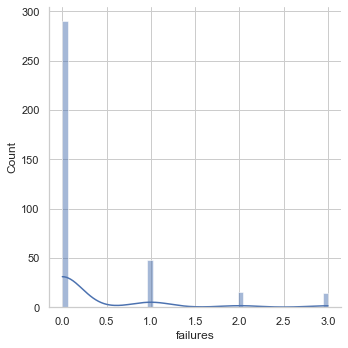

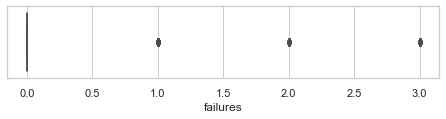

In [27]:
stats('failures')

Замененим nan на 0 и 1 в соотношении 6:1

Показатели для -= failures =-:

Общее количество значений (non-NA/null значений): 389 (389)
Уникальные значения: [0.0, 1.0, 2.0, 3.0]
Минимум: 0.0
Максимум: 3.0
Мода: [0.0]
Медиана: 0.0
Среднее: 0.3188
STD: 0.7152
25-й перцентиль: 0.0
75-й перцентиль: 0.0
IQR: 0.0, кол-во значений: 308, 79.18%
Границы выбросов: [0.0, 0.0], кол-во значений: 308, 79.18%
Выбросы слева: [], количество выбросов: 0
Выбросы справа: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0], количество выбросов: 81


,values,counts,%
0,0.0,308,79.177378
1,1.0,52,13.367609
2,2.0,15,3.856041
3,3.0,14,3.598972


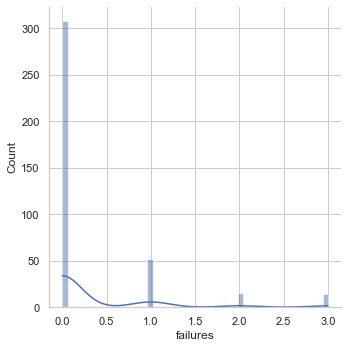

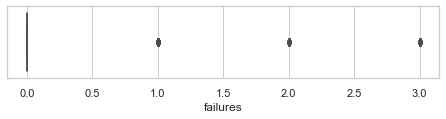

In [28]:
nan_to_values('failures',7,1,0)
stats('failures')

Показатели для -= famrel =-:

Общее количество значений (non-NA/null значений): 389 (362)
Уникальные значения: [-1.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan]
Минимум: -1.0
Максимум: 5.0
Мода: [4.0]
Медиана: 4.0
Среднее: 3.9309
STD: 0.9316
25-й перцентиль: 4.0
75-й перцентиль: 5.0
IQR: 1.0, кол-во значений: 275, 75.97%
Границы выбросов: [2.5, 6.5], кол-во значений: 337, 93.09%
Выбросы слева: [-1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], количество выбросов: 25
Выбросы справа: [], количество выбросов: 0


,values,counts,%
0,4.0,178,45.758355
1,5.0,97,24.935733
2,3.0,62,15.938303
3,NaN,27,6.940874
4,2.0,17,4.370180
5,1.0,7,1.799486
6,-1.0,1,0.257069


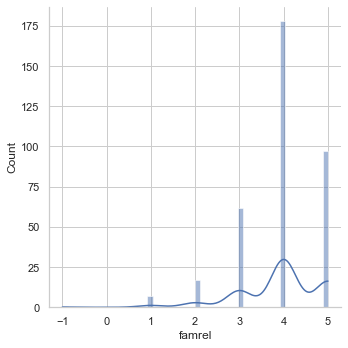

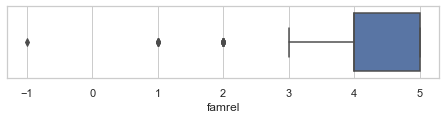

In [29]:
stats('famrel')

Заменим -1 на 1 и nan на медиану и, учитывая, что столбец фактически содержит номинативные данные, произведем соответствующую замену.

Показатели для -= famrel =-:


,famrel
count,389
unique,5
top,хорошо
freq,205


,values,counts,%
0,хорошо,205,52.699229
1,очень хорошо,97,24.935733
2,нормально,62,15.938303
3,плохо,17,4.370180
4,очень плохо,8,2.056555


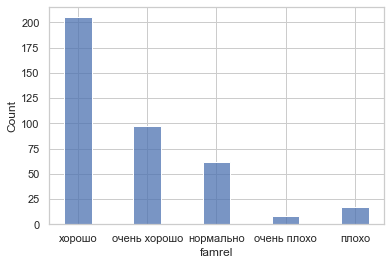

In [30]:
change_column('famrel', -1, 1)
change_column('famrel', None, stud['famrel'].median())
change_column('famrel', 1, 'очень плохо')
change_column('famrel', 2, 'плохо')
change_column('famrel', 3, 'нормально')
change_column('famrel', 4, 'хорошо')
change_column('famrel', 5, 'очень хорошо')
stats('famrel')

Показатели для -= freetime =-:

Общее количество значений (non-NA/null значений): 389 (380)
Уникальные значения: [1.0, 2.0, 3.0, 4.0, 5.0, nan]
Минимум: 1.0
Максимум: 5.0
Мода: [3.0]
Медиана: 3.0
Среднее: 3.2237
STD: 0.9934
25-й перцентиль: 3.0
75-й перцентиль: 4.0
IQR: 1.0, кол-во значений: 262, 68.95%
Границы выбросов: [1.5, 5.5], кол-во значений: 362, 95.26%
Выбросы слева: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], количество выбросов: 18
Выбросы справа: [], количество выбросов: 0


,values,counts,%
0,3.0,152,39.074550
1,4.0,110,28.277635
2,2.0,63,16.195373
3,5.0,37,9.511568
4,1.0,18,4.627249
5,NaN,9,2.313625


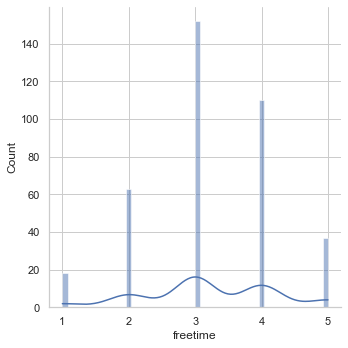

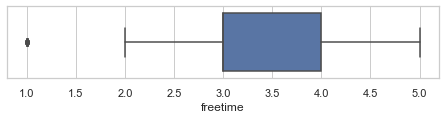

In [31]:
stats('freetime')

Заменим nan на медиану  и, учитывая, что столбец фактически содержит номинативные данные, произведем соответствующую замену.

Показатели для -= freetime =-:


,freetime
count,389
unique,5
top,нормально
freq,161


,values,counts,%
0,нормально,161,41.388175
1,много,110,28.277635
2,мало,63,16.195373
3,очень много,37,9.511568
4,очень мало,18,4.627249


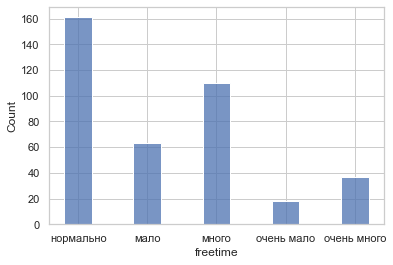

In [32]:
change_column('freetime', None, stud['freetime'].median())
change_column('freetime', 1, 'очень мало')
change_column('freetime', 2, 'мало')
change_column('freetime', 3, 'нормально')
change_column('freetime', 4, 'много')
change_column('freetime', 5, 'очень много')
stats('freetime')

Показатели для -= goout =-:

Общее количество значений (non-NA/null значений): 389 (382)
Уникальные значения: [1.0, 2.0, 3.0, 4.0, 5.0, nan]
Минимум: 1.0
Максимум: 5.0
Мода: [3.0]
Медиана: 3.0
Среднее: 3.0942
STD: 1.1161
25-й перцентиль: 2.0
75-й перцентиль: 4.0
IQR: 2.0, кол-во значений: 308, 80.63%
Границы выбросов: [-1.0, 7.0], кол-во значений: 382, 100.0%
Выбросы слева: [], количество выбросов: 0
Выбросы справа: [], количество выбросов: 0


,values,counts,%
0,3.0,126,32.390746
1,2.0,101,25.964010
2,4.0,81,20.822622
3,5.0,51,13.110540
4,1.0,23,5.912596
5,NaN,7,1.799486


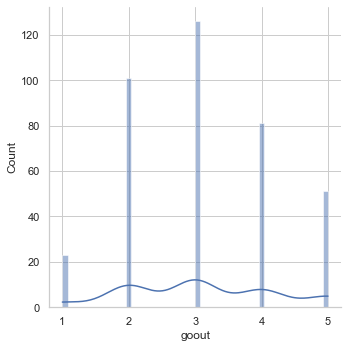

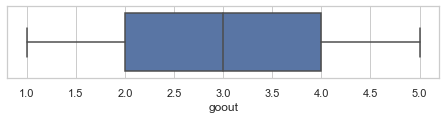

In [33]:
stats('goout')

Заменим nan на медиану и, учитывая, что столбец фактически содержит номинативные данные, произведем соответствующую замену.

Показатели для -= goout =-:


,goout
count,389
unique,5
top,нормально
freq,133


,values,counts,%
0,нормально,133,34.190231
1,мало,101,25.964010
2,много,81,20.822622
3,очень много,51,13.110540
4,очень мало,23,5.912596


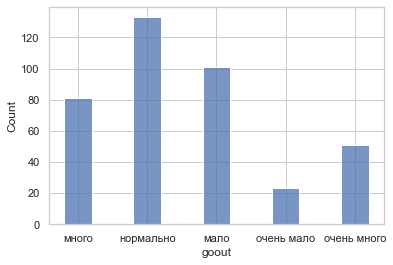

In [34]:
change_column('goout', None, stud['goout'].median())
change_column('goout', 1, 'очень мало')
change_column('goout', 2, 'мало')
change_column('goout', 3, 'нормально')
change_column('goout', 4, 'много')
change_column('goout', 5, 'очень много')
stats('goout')

Показатели для -= health =-:

Общее количество значений (non-NA/null значений): 389 (374)
Уникальные значения: [1.0, 2.0, 3.0, 4.0, 5.0, nan]
Минимум: 1.0
Максимум: 5.0
Мода: [5.0]
Медиана: 4.0
Среднее: 3.5294
STD: 1.402
25-й перцентиль: 3.0
75-й перцентиль: 5.0
IQR: 2.0, кол-во значений: 285, 76.2%
Границы выбросов: [0.0, 8.0], кол-во значений: 374, 100.0%
Выбросы слева: [], количество выбросов: 0
Выбросы справа: [], количество выбросов: 0


,values,counts,%
0,5.0,137,35.218509
1,3.0,88,22.622108
2,4.0,60,15.424165
3,1.0,47,12.082262
4,2.0,42,10.796915
5,NaN,15,3.856041


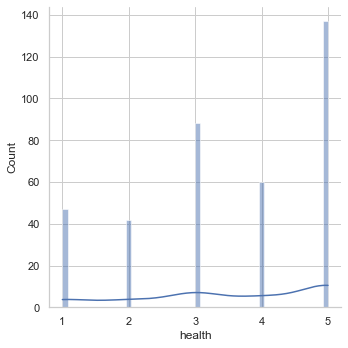

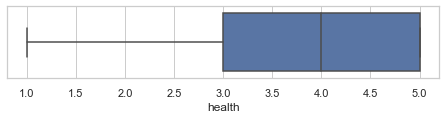

In [35]:
stats('health')

Заменим nan на медиану и, учитывая, что столбец фактически содержит номинативные данные, произведем соответствующую замену.

Показатели для -= health =-:


,health
count,389
unique,5
top,очень хорошо
freq,137


,values,counts,%
0,очень хорошо,137,35.218509
1,нормально,88,22.622108
2,хорошо,75,19.280206
3,очень плохо,47,12.082262
4,плохо,42,10.796915


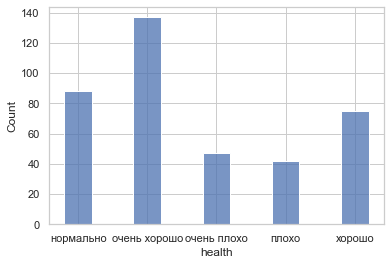

In [36]:
change_column('health', None, stud['health'].median())
change_column('health', 1, 'очень плохо')
change_column('health', 2, 'плохо')
change_column('health', 3, 'нормально')
change_column('health', 4, 'хорошо')
change_column('health', 5, 'очень хорошо')
stats('health')

Показатели для -= absences =-:

Общее количество значений (non-NA/null значений): 389 (378)
Уникальные значения: [0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 13.0, 14.0, 16.0, nan, 1.0, 11.0, 15.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 28.0, 30.0, 38.0, 40.0, 54.0, 56.0, 75.0, 212.0, 385.0]
Минимум: 0.0
Максимум: 385.0
Мода: [0.0]
Медиана: 4.0
Среднее: 7.3201
STD: 23.6155
25-й перцентиль: 0.0
75-й перцентиль: 8.0
IQR: 8.0, кол-во значений: 293, 77.51%
Границы выбросов: [-12.0, 20.0], кол-во значений: 361, 95.5%
Выбросы слева: [], количество выбросов: 0
Выбросы справа: [21.0, 22.0, 22.0, 22.0, 23.0, 24.0, 25.0, 26.0, 28.0, 30.0, 38.0, 40.0, 54.0, 56.0, 75.0, 212.0, 385.0], количество выбросов: 17


,values,counts,%
0,0.0,110,28.277635
1,2.0,60,15.424165
2,4.0,52,13.367609
3,6.0,30,7.712082
4,8.0,20,5.141388
...,...,...,...
32,38.0,1,0.257069
33,40.0,1,0.257069
34,23.0,1,0.257069
35,17.0,1,0.257069


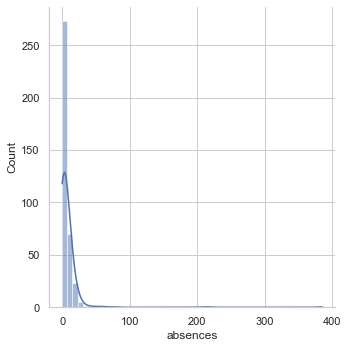

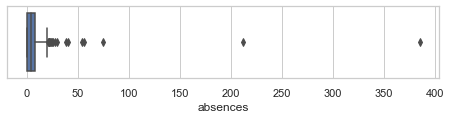

In [37]:
stats('absences')

Заменим nan на медиану.

Показатели для -= absences =-:

Общее количество значений (non-NA/null значений): 389 (389)
Уникальные значения: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 28.0, 30.0, 38.0, 40.0, 54.0, 56.0, 75.0, 212.0, 385.0]
Минимум: 0.0
Максимум: 385.0
Мода: [0.0]
Медиана: 4.0
Среднее: 7.2262
STD: 23.2849
25-й перцентиль: 0.0
75-й перцентиль: 8.0
IQR: 8.0, кол-во значений: 304, 78.15%
Границы выбросов: [-12.0, 20.0], кол-во значений: 372, 95.63%
Выбросы слева: [], количество выбросов: 0
Выбросы справа: [21.0, 22.0, 22.0, 22.0, 23.0, 24.0, 25.0, 26.0, 28.0, 30.0, 38.0, 40.0, 54.0, 56.0, 75.0, 212.0, 385.0], количество выбросов: 17


,values,counts,%
0,0.0,110,28.277635
1,4.0,63,16.195373
2,2.0,60,15.424165
3,6.0,30,7.712082
4,8.0,20,5.141388
...,...,...,...
31,38.0,1,0.257069
32,40.0,1,0.257069
33,23.0,1,0.257069
34,17.0,1,0.257069


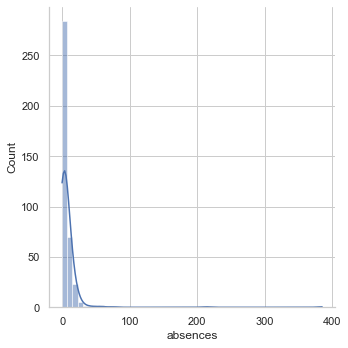

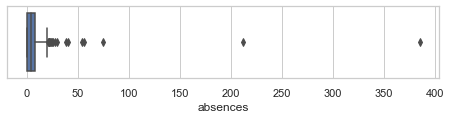

In [38]:
change_column('absences', None, stud['absences'].median())
stats('absences')

Удалим выбросы. В году 52 недели. Летние каникулы - 12-13 недель, другие праздники не учитываем. Учебных недель 39-40. Значения 212,385 не имеют смысла, т.к. больше учебных дней в году. Заменим их на медиану.

Показатели для -= absences =-:

Общее количество значений (non-NA/null значений): 389 (389)
Уникальные значения: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 28.0, 30.0, 38.0, 40.0, 54.0, 56.0, 75.0]
Минимум: 0.0
Максимум: 75.0
Мода: [0.0]
Медиана: 4.0
Среднее: 5.7121
STD: 8.0032
25-й перцентиль: 0.0
75-й перцентиль: 8.0
IQR: 8.0, кол-во значений: 306, 78.66%
Границы выбросов: [-12.0, 20.0], кол-во значений: 374, 96.14%
Выбросы слева: [], количество выбросов: 0
Выбросы справа: [21.0, 22.0, 22.0, 22.0, 23.0, 24.0, 25.0, 26.0, 28.0, 30.0, 38.0, 40.0, 54.0, 56.0, 75.0], количество выбросов: 15


,values,counts,%
0,0.0,110,28.277635
1,4.0,65,16.709512
2,2.0,60,15.424165
3,6.0,30,7.712082
4,8.0,20,5.141388
5,10.0,17,4.370180
6,14.0,12,3.084833
7,12.0,12,3.084833
8,3.0,7,1.799486
9,16.0,7,1.799486


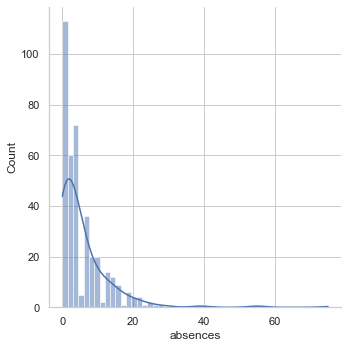

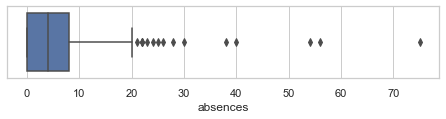

In [39]:
change_column('absences', 212, stud['absences'].median())
change_column('absences', 385, stud['absences'].median())
stats('absences')

Посмотрим не числовые характеристики

In [40]:
columns_type('o')

,school,sex,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health
0,GP,F,U,None,A,высшее,высшее,at_home,teacher,course,mother,yes,no,no,no,yes,yes,None,no,хорошо,нормально,много,нормально
1,GP,F,U,GT3,None,4 класса,4 класса,at_home,other,course,father,no,yes,no,no,no,yes,yes,no,очень хорошо,нормально,нормально,нормально
2,GP,F,U,LE3,T,4 класса,4 класса,at_home,other,other,mother,yes,no,None,no,yes,yes,yes,None,хорошо,нормально,мало,нормально
3,GP,F,U,GT3,T,высшее,5-9 классы,health,None,home,mother,no,yes,yes,yes,yes,yes,yes,yes,нормально,мало,мало,очень хорошо
4,GP,F,U,GT3,T,сред.спец / 11 классов,сред.спец / 11 классов,other,other,home,father,no,yes,yes,no,yes,yes,no,no,хорошо,нормально,мало,очень хорошо
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,MS,M,U,LE3,A,5-9 классы,5-9 классы,services,services,course,None,no,yes,yes,no,yes,yes,no,no,очень хорошо,очень много,много,хорошо
385,MS,M,U,LE3,T,сред.спец / 11 классов,4 класса,services,services,course,mother,no,no,no,no,no,yes,yes,no,плохо,много,очень много,плохо
386,MS,M,R,GT3,T,4 класса,4 класса,other,other,course,None,None,no,no,no,no,None,no,no,очень хорошо,очень много,нормально,нормально
387,MS,M,R,LE3,T,сред.спец / 11 классов,5-9 классы,services,other,course,mother,no,no,no,None,no,yes,yes,no,хорошо,много,очень мало,очень хорошо


Показатели для -= address =-:


,address
count,374
unique,2
top,U
freq,291


,values,counts,%
0,U,291,74.807198
1,R,83,21.336761
2,NaN,15,3.856041


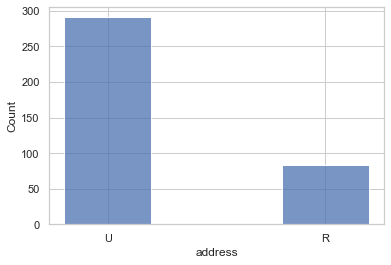

In [41]:
stats('address')

Заменим nan на значения исходя из пропорции 4:1

Показатели для -= address =-:


,address
count,389
unique,2
top,U
freq,303


,values,counts,%
0,U,303,77.892031
1,R,86,22.107969


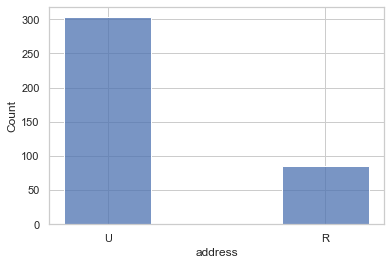

In [42]:
nan_to_values('address',5,'R','U')
stats('address')

Показатели для -= famsize =-:


,famsize
count,362
unique,2
top,GT3
freq,255


,values,counts,%
0,GT3,255,65.552699
1,LE3,107,27.506427
2,NaN,27,6.940874


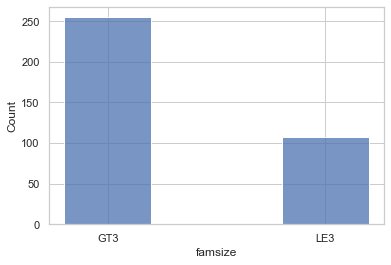

In [43]:
stats('famsize')

Заменим nan на значения исходя из пропорции 2:1

Показатели для -= famsize =-:


,famsize
count,389
unique,2
top,GT3
freq,273


,values,counts,%
0,GT3,273,70.179949
1,LE3,116,29.820051


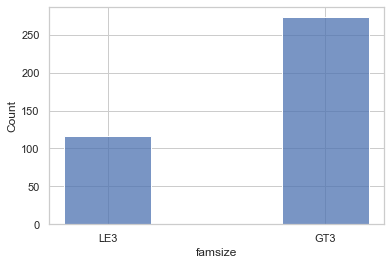

In [44]:
nan_to_values ('famsize',3,'LE3','GT3')
stats('famsize')

Показатели для -= Pstatus =-:


,Pstatus
count,344
unique,2
top,T
freq,308


,values,counts,%
0,T,308,79.177378
1,NaN,45,11.568123
2,A,36,9.254499


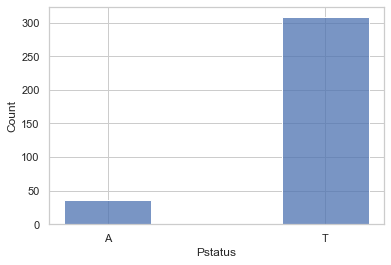

In [45]:
stats('Pstatus')

Заменим nan на значения исходя из пропорции 9:1

Показатели для -= Pstatus =-:


,Pstatus
count,389
unique,2
top,T
freq,348


,values,counts,%
0,T,348,89.460154
1,A,41,10.539846


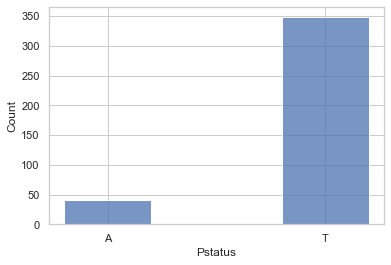

In [46]:
nan_to_values ('Pstatus',10,'A','T')
stats('Pstatus')

Показатели для -= Mjob =-:


,Mjob
count,370
unique,5
top,other
freq,127


,values,counts,%
0,other,127,32.647815
1,services,98,25.192802
2,at_home,58,14.910026
3,teacher,55,14.138817
4,health,32,8.226221
5,NaN,19,4.884319


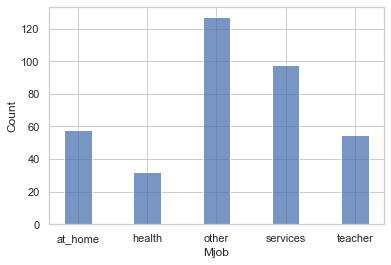

In [47]:
stats('Mjob')

Заменим nan на моду

Показатели для -= Mjob =-:


,Mjob
count,389
unique,5
top,other
freq,146


,values,counts,%
0,other,146,37.532134
1,services,98,25.192802
2,at_home,58,14.910026
3,teacher,55,14.138817
4,health,32,8.226221


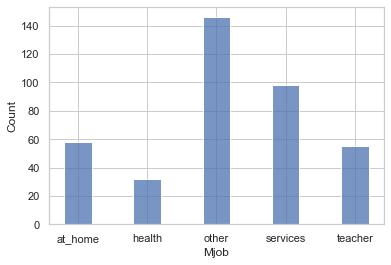

In [48]:
change_column('Mjob', None, 'other')
stats('Mjob')

Показатели для -= Fjob =-:


,Fjob
count,353
unique,5
top,other
freq,194


,values,counts,%
0,other,194,49.871465
1,services,99,25.449871
2,NaN,36,9.254499
3,teacher,29,7.455013
4,at_home,16,4.113111
5,health,15,3.856041


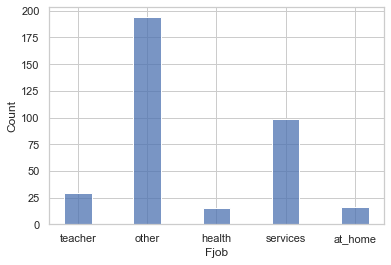

In [49]:
stats('Fjob')

Заменим nan на моду

Показатели для -= Fjob =-:


,Fjob
count,389
unique,5
top,other
freq,230


,values,counts,%
0,other,230,59.125964
1,services,99,25.449871
2,teacher,29,7.455013
3,at_home,16,4.113111
4,health,15,3.856041


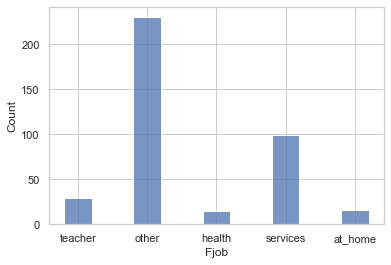

In [50]:
change_column('Fjob', None, 'other')
stats('Fjob')

Показатели для -= reason =-:


,reason
count,372
unique,4
top,course
freq,135


,values,counts,%
0,course,135,34.70437
1,reputation,102,26.22108
2,home,101,25.96401
3,other,34,8.74036
4,NaN,17,4.37018


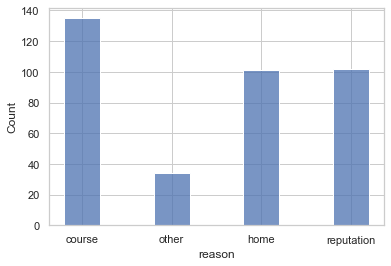

In [51]:
stats('reason')

Заменим nan на моду

Показатели для -= reason =-:


,reason
count,389
unique,4
top,course
freq,152


,values,counts,%
0,course,152,39.07455
1,reputation,102,26.22108
2,home,101,25.96401
3,other,34,8.74036


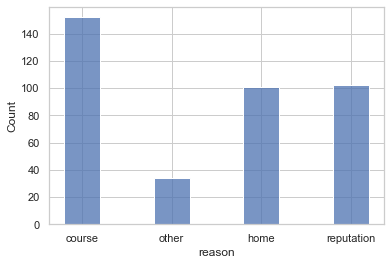

In [52]:
change_column('reason', None, 'course')
stats('reason')

Показатели для -= guardian =-:


,guardian
count,358
unique,3
top,mother
freq,248


,values,counts,%
0,mother,248,63.753213
1,father,86,22.107969
2,NaN,31,7.969152
3,other,24,6.169666


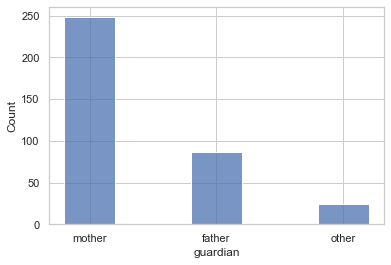

In [53]:
stats('guardian')

Заменим nan на значения исходя из пропорции 3:1

Показатели для -= guardian =-:


,guardian
count,389
unique,3
top,mother
freq,271


,values,counts,%
0,mother,271,69.665810
1,father,94,24.164524
2,other,24,6.169666


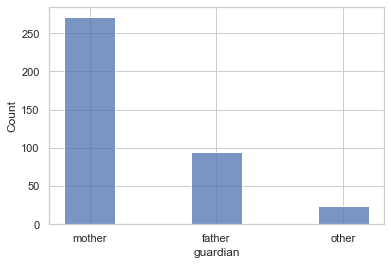

In [54]:
nan_to_values ('guardian',4,'father','mother')
stats('guardian')

Показатели для -= schoolsup =-:


,schoolsup
count,380
unique,2
top,no
freq,331


,values,counts,%
0,no,331,85.089974
1,yes,49,12.596401
2,NaN,9,2.313625


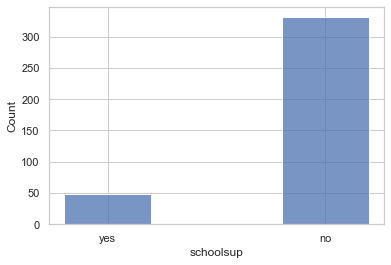

In [55]:
stats('schoolsup')

Заменим nan на значения исходя из пропорции 6:1

Показатели для -= schoolsup =-:


,schoolsup
count,389
unique,2
top,no
freq,338


,values,counts,%
0,no,338,86.88946
1,yes,51,13.11054


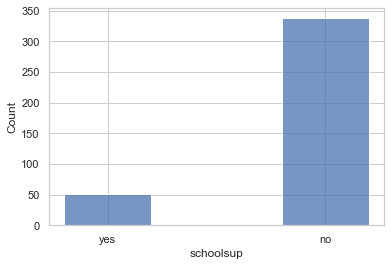

In [56]:
nan_to_values ('schoolsup',7,'yes','no')
stats('schoolsup')

Показатели для -= famsup =-:


,famsup
count,351
unique,2
top,yes
freq,216


,values,counts,%
0,yes,216,55.526992
1,no,135,34.704370
2,NaN,38,9.768638


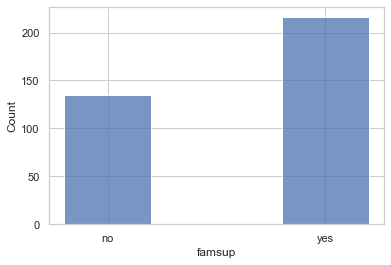

In [57]:
stats('famsup')

Заменим nan на значения исходя из пропорции 2:1

Показатели для -= famsup =-:


,famsup
count,389
unique,2
top,yes
freq,241


,values,counts,%
0,yes,241,61.953728
1,no,148,38.046272


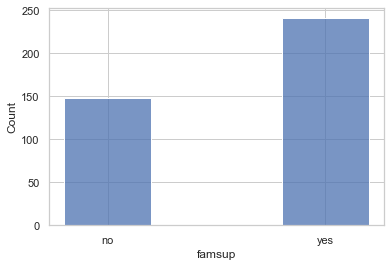

In [58]:
nan_to_values ('famsup',3,'no','yes')
stats('famsup')

Показатели для -= paid =-:


,paid
count,350
unique,2
top,no
freq,197


,values,counts,%
0,no,197,50.642674
1,yes,153,39.331620
2,NaN,39,10.025707


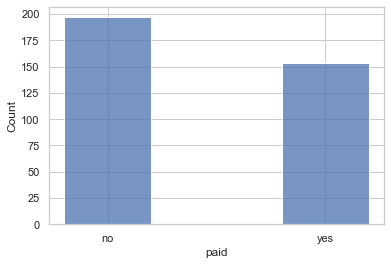

In [59]:
stats('paid')

Заменим nan на значения исходя из пропорции 1:1

Показатели для -= paid =-:


,paid
count,389
unique,2
top,no
freq,216


,values,counts,%
0,no,216,55.526992
1,yes,173,44.473008


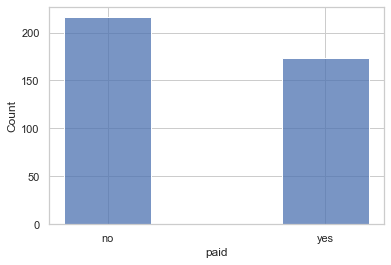

In [60]:
nan_to_values ('paid',2,'yes','no')
stats('paid')

Показатели для -= activities =-:


,activities
count,375
unique,2
top,yes
freq,192


,values,counts,%
0,yes,192,49.357326
1,no,183,47.043702
2,NaN,14,3.598972


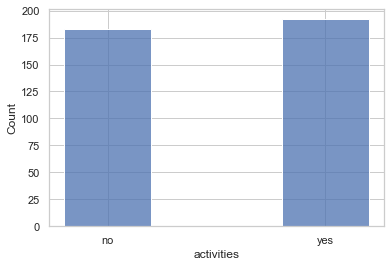

In [61]:
stats('activities')

Заменим nan на значения исходя из пропорции 1:1

Показатели для -= activities =-:


,activities
count,389
unique,2
top,yes
freq,199


,values,counts,%
0,yes,199,51.156812
1,no,190,48.843188


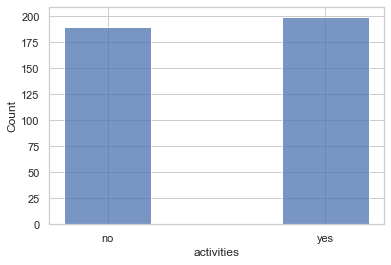

In [62]:
nan_to_values ('activities',2,'no','yes')
stats('activities')

Показатели для -= nursery =-:


,nursery
count,374
unique,2
top,yes
freq,297


,values,counts,%
0,yes,297,76.349614
1,no,77,19.794344
2,NaN,15,3.856041


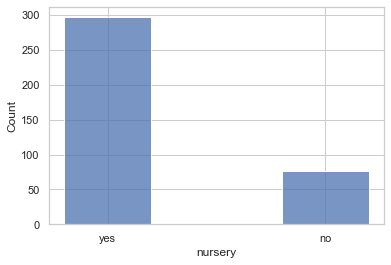

In [63]:
stats('nursery')

Заменим nan на значения исходя из пропорции 4:1

Показатели для -= nursery =-:


,nursery
count,389
unique,2
top,yes
freq,309


,values,counts,%
0,yes,309,79.434447
1,no,80,20.565553


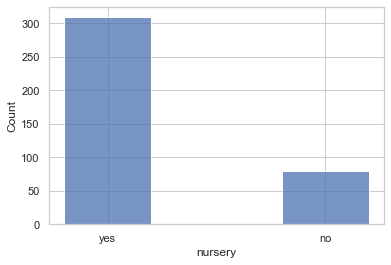

In [64]:
nan_to_values ('nursery',5,'no','yes')
stats('nursery')

Показатели для -= higher =-:


,higher
count,369
unique,2
top,yes
freq,350


,values,counts,%
0,yes,350,89.974293
1,NaN,20,5.141388
2,no,19,4.884319


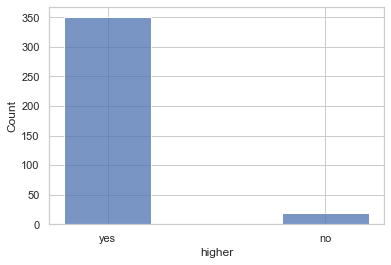

In [65]:
stats('higher')

Заменим nan моду

Показатели для -= higher =-:


,higher
count,389
unique,2
top,yes
freq,370


,values,counts,%
0,yes,370,95.115681
1,no,19,4.884319


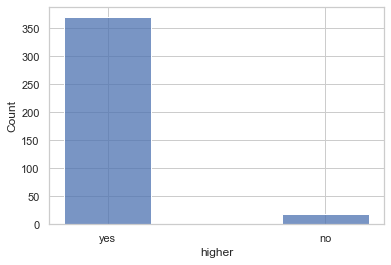

In [66]:
change_column('higher',None,'yes')
stats('higher')

Показатели для -= internet =-:


,internet
count,355
unique,2
top,yes
freq,300


,values,counts,%
0,yes,300,77.120823
1,no,55,14.138817
2,NaN,34,8.740360


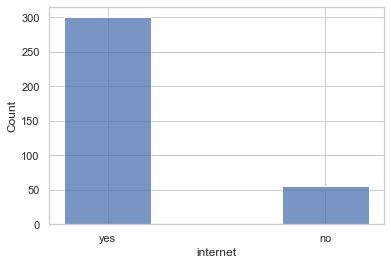

In [67]:
stats('internet')

Заменим nan на значения исходя из пропорции 6:1

Показатели для -= internet =-:


,internet
count,389
unique,2
top,yes
freq,329


,values,counts,%
0,yes,329,84.575835
1,no,60,15.424165


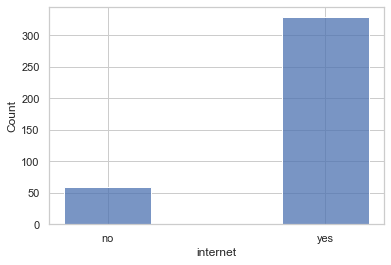

In [68]:
nan_to_values ('internet',7,'no','yes')
stats('internet')

Показатели для -= romantic =-:


,romantic
count,358
unique,2
top,no
freq,235


,values,counts,%
0,no,235,60.411311
1,yes,123,31.619537
2,NaN,31,7.969152


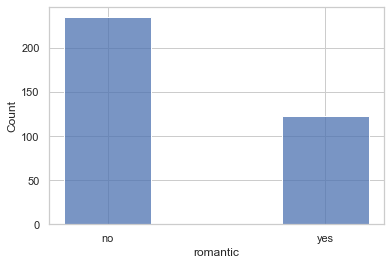

In [69]:
stats('romantic')

Заменим nan на значения исходя из пропорции 2:1

Показатели для -= romantic =-:


,romantic
count,389
unique,2
top,no
freq,255


,values,counts,%
0,no,255,65.552699
1,yes,134,34.447301


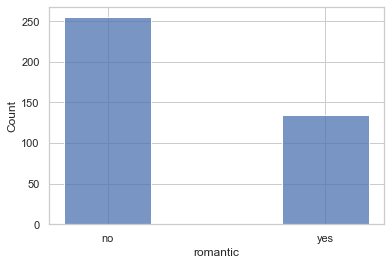

In [70]:
nan_to_values ('romantic',3,'yes','no')
stats('romantic')

После преобразования данных в характеристиках вновь посмотрим корреляцию для числовых признаков и проведем тест Стьюдента для номинативных

Количество характеристик: 5


age          -0.155726
traveltime   -0.048564
studytime     0.099506
failures     -0.333410
absences      0.028220
Name: score, dtype: float64

Максимальный коэффициент: failures   -0.33341
Name: score, dtype: float64 

Минимальный коэффициент: absences    0.02822
Name: score, dtype: float64


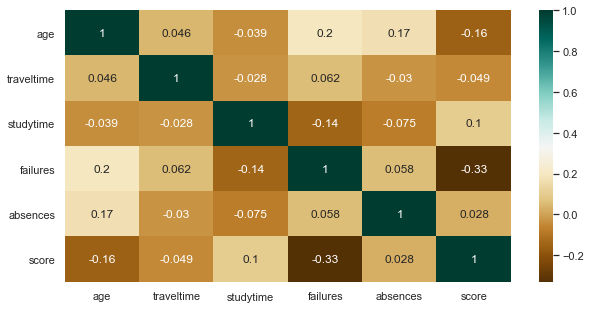

In [71]:
heat_map()

Найдены статистически значимые различия для колонки address p-value= 0.0288
Найдены статистически значимые различия для колонки Medu p-value= 0.0017
Найдены статистически значимые различия для колонки Mjob p-value= 0.0042
Найдены статистически значимые различия для колонки higher p-value= 0.0003
Найдены статистически значимые различия для колонки romantic p-value= 0.0129

 Графики для address


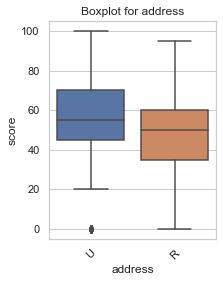

R


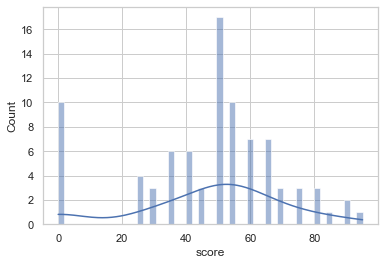

U


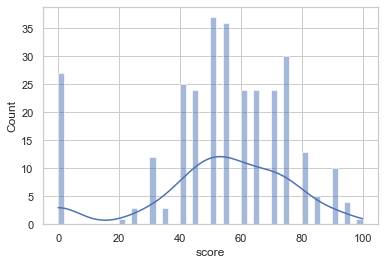


 Графики для Medu


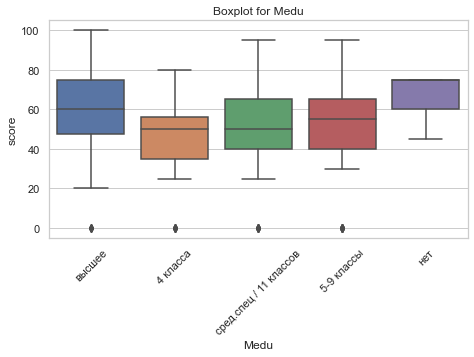

4 класса


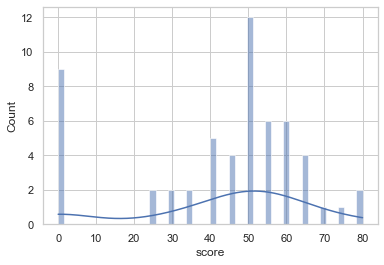

5-9 классы


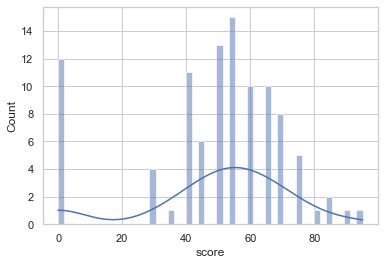

высшее


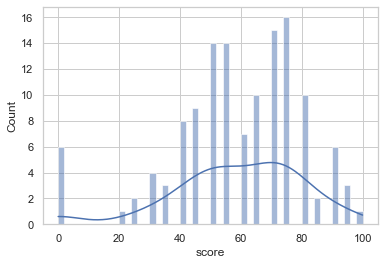

нет


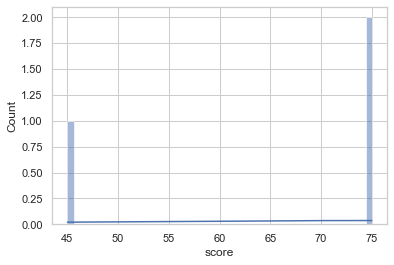

сред.спец / 11 классов


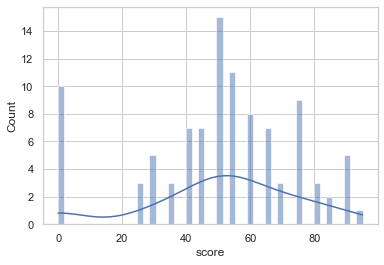


 Графики для Mjob


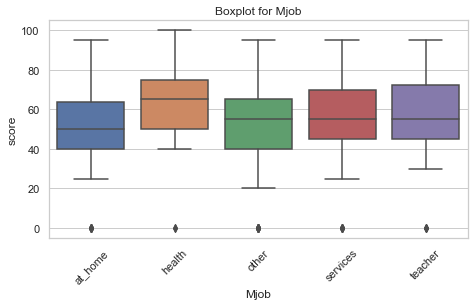

at_home


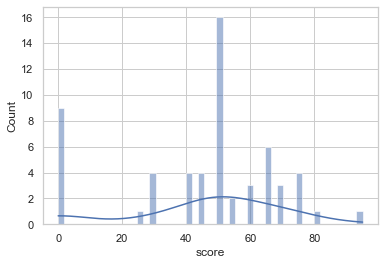

health


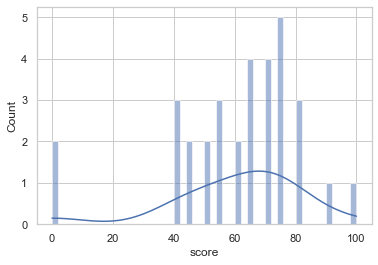

other


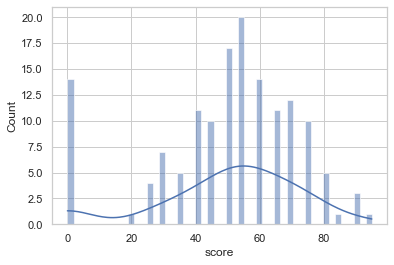

services


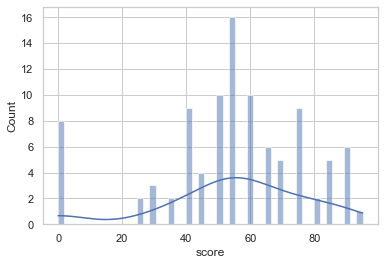

teacher


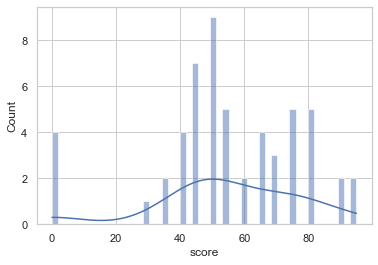


 Графики для higher


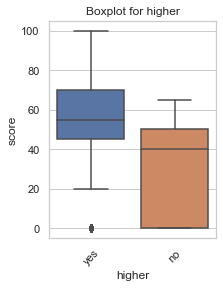

no


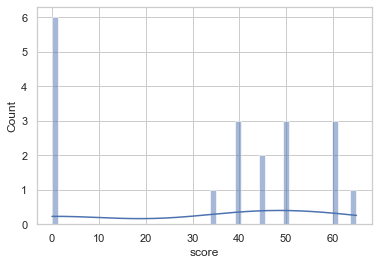

yes


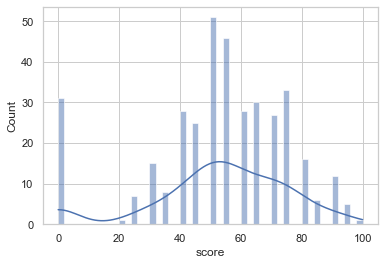


 Графики для romantic


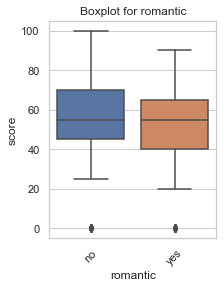

no


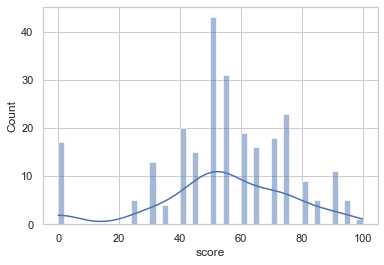

yes


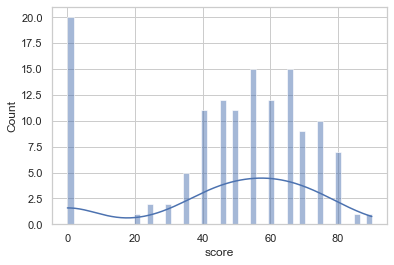

In [72]:
score_nominative()

Подробно посмотрим на  числовые харктеристики, имеющие наибольшие коэффициенты корреляции - age и failures, с разбивкой на пол учеников (как неотъемлемую характеристику ученика)

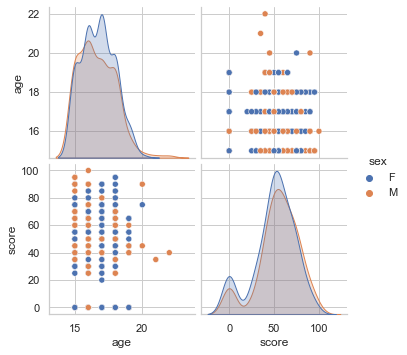

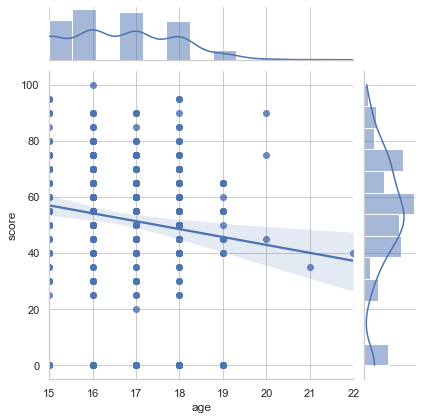

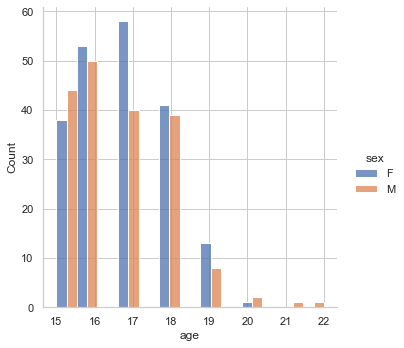

In [73]:
# Характеристика age          -0.155726
sns.pairplot(stud[['age','sex','score']],hue='sex')
sns.jointplot(x='age', y='score', data=stud, kind='reg')
sns.displot(x='age',hue='sex', multiple='dodge', data=stud)

In [74]:
display((stud[stud.score>=80].sex.value_counts()))
display(stud[stud.age.between(15,18)].sex.value_counts())
display((stud[stud.score<=20].sex.value_counts()))
display(stud[stud.age.between(15,19)].sex.value_counts())
display(stud[stud.age>=20].score.value_counts())

M    24
F    16
Name: sex, dtype: int64

F    190
M    173
Name: sex, dtype: int64

F    23
M    15
Name: sex, dtype: int64

F    203
M    181
Name: sex, dtype: int64

35.0    1
45.0    1
75.0    1
90.0    1
40.0    1
Name: score, dtype: int64

1. Высокие оценки (от 80 и выше) присуще учащимся от 15 до 18 лет. При этом учащихся мужского пола, получивших высокие оценки, больше. В самой же возврастной группе больше учащихся женского пола.
2. Низкие оценки (от 20 и ниже) присуще учащимся от 15 до 19 лет. При этом учащихся женского пола, получивших низкие оценки, больше. В самой возврастной группе также больше учащихся женского пола.
3. В группе 19+, которая выглядит как выброс, присутствуют как высокие оценки - 90, так и довольно низкие - 35.

Характеристика failures     -0.333410

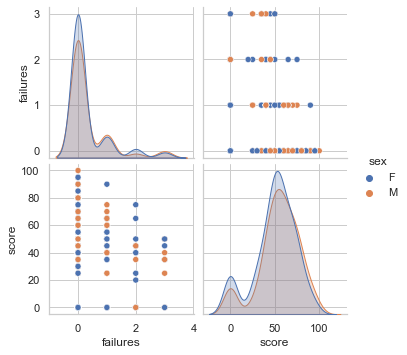

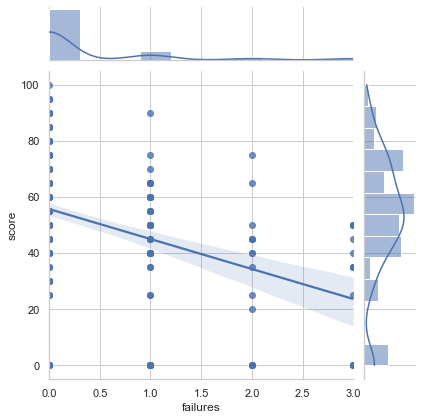

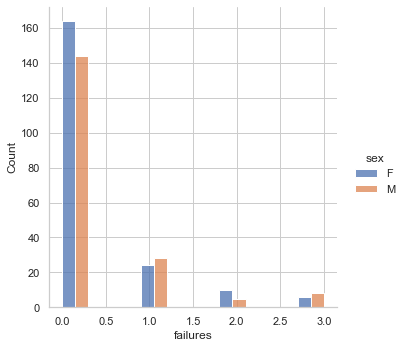

In [75]:
sns.pairplot(stud[['failures','sex','score']],hue='sex')
sns.jointplot(x='failures', y='score', data=stud, kind='reg')
sns.displot(x='failures',hue='sex', multiple='dodge', data=stud)

In [76]:
display(stud[stud.failures>=2].score.value_counts())

0.0     8
50.0    5
35.0    4
45.0    4
40.0    3
25.0    2
75.0    1
65.0    1
20.0    1
Name: score, dtype: int64

Характеристика failures - количество внеучебных неудач (не известно, что именно за неудачи и какое отношение они имеют к учебному процессу), при значениях 2 и 3 в ~97% оценка по экзамену не превышает 50 баллов (Мода: 50.0, Медиана: 55.0, Среднее: 52.2622).

После преобразования, очистки и заполнения данных, в числовых характристиках осталось 5 из 12, при этом корреляция age score осталась без изменений, traveltime и studytime после уточнения значений уменьшилась на ~15 и 45%, absences увеличилась почти в 4 раза. Максимальный кооэффициент корреляции незначительно уменьшился.

Услово разделим score на 4 группы исходя из полученных баллов: 1. [0:25] - очень плохо, 2. (25:50] - плохо, 3. (50:75] - нормально, 4. (75:100] - хорошо. Учитывая, что нас интересуют характеристики, которые могут оказать влияние на студентов таким образом, что их оценки на экзамене будут низкими, отдельно рассмотрим  1 и 2 группы.

Количество характеристик: 5


age          -0.066111
traveltime    0.069907
studytime    -0.031643
failures     -0.163510
absences      0.247435
Name: score, dtype: float64

Максимальный коэффициент: absences    0.247435
Name: score, dtype: float64 

Минимальный коэффициент: studytime   -0.031643
Name: score, dtype: float64


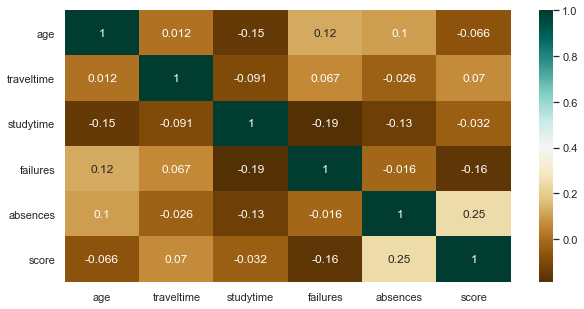

In [77]:
stud_bad = stud[stud.score<=50]
heat_map(stud_bad)

Найдены статистически значимые различия для колонки paid p-value= 0.0039
Найдены статистически значимые различия для колонки romantic p-value= 0.0058

 Графики для paid


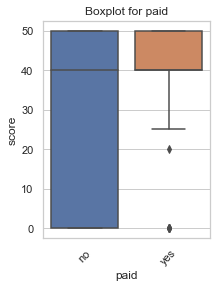

no


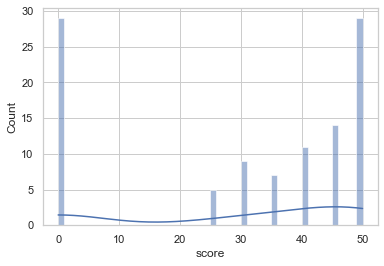

yes


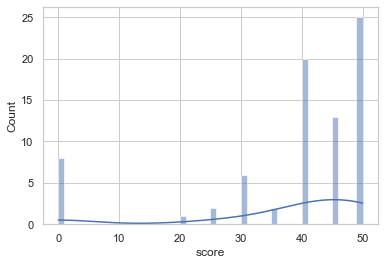


 Графики для romantic


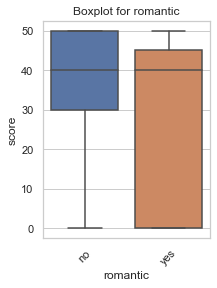

no


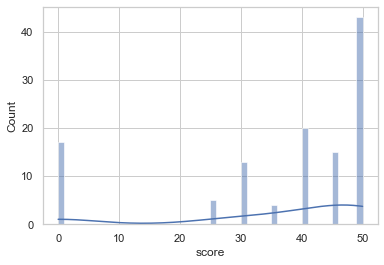

yes


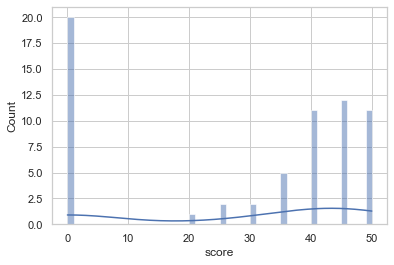

In [78]:
score_nominative(stud_bad)

In [79]:
# sns.jointplot(x='absences', y='score', data=stud, kind='reg')
# sns.jointplot(x='absences', y='score', data=stud_bad, kind='reg')
# get_boxplot('absences','score',stud_bad)

Учитывая ранее полученную информацию по распределению score в возрастных группах по полу, попробуем посмотреть отдельно данные для мужчин и женщин

In [80]:
stud_m = stud_bad[stud_bad.sex == 'M']
stud_f = stud_bad[stud_bad.sex == 'F']
display(stud_m.corr().score)
display(stud_f.corr().score)
display((stud_m.corr().score).compare(stud_f.corr().score))

age          -0.052557
traveltime    0.152106
studytime     0.028824
failures     -0.213915
absences      0.290183
score         1.000000
Name: score, dtype: float64

age          -0.094481
traveltime   -0.049905
studytime    -0.045227
failures     -0.134882
absences      0.227384
score         1.000000
Name: score, dtype: float64

,self,other
age,-0.052557,-0.094481
traveltime,0.152106,-0.049905
studytime,0.028824,-0.045227
failures,-0.213915,-0.134882
absences,0.290183,0.227384


Найдены статистически значимые различия для колонки Fedu p-value= 0.0046
Найдены статистически значимые различия для колонки paid p-value= 0.0221
Найдены статистически значимые различия для колонки higher p-value= 0.0444

 Графики для Fedu


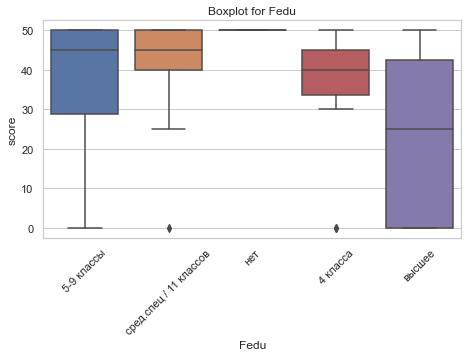

4 класса


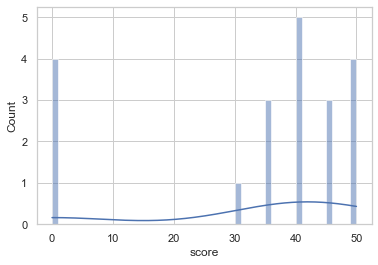

5-9 классы


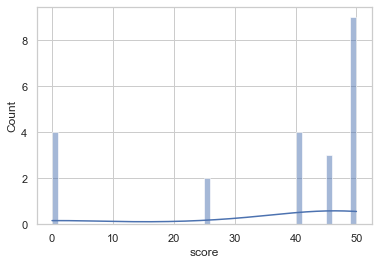

высшее


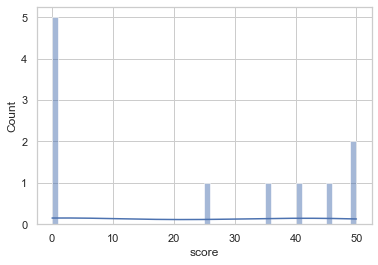

нет


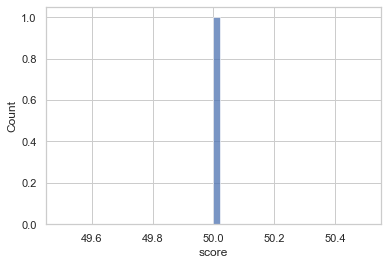

сред.спец / 11 классов


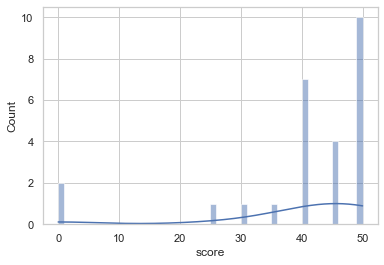


 Графики для paid


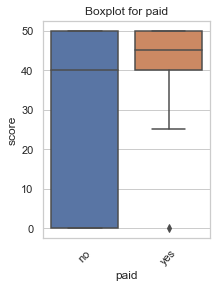

no


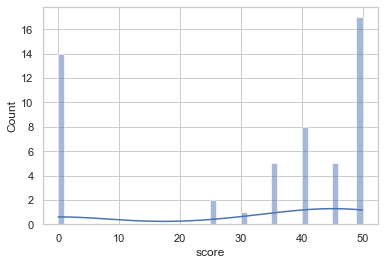

yes


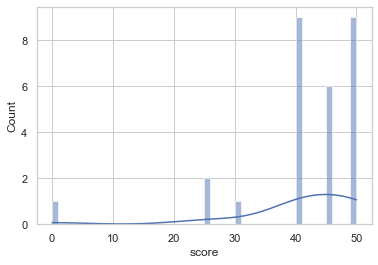


 Графики для higher


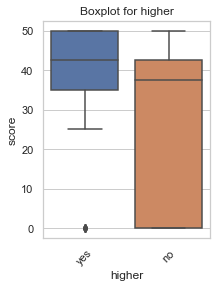

no


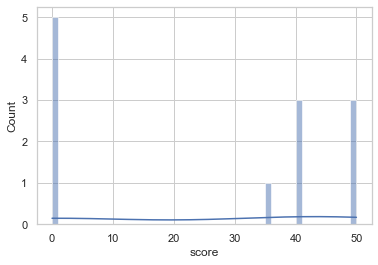

yes


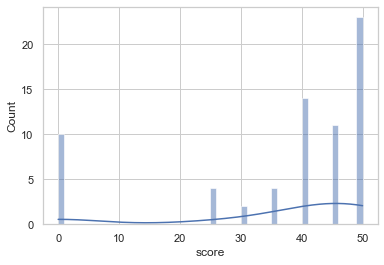

In [81]:
score_nominative(stud_m)

Найдены статистически значимые различия для колонки schoolsup p-value= 0.0467
Найдены статистически значимые различия для колонки paid p-value= 0.0424
Найдены статистически значимые различия для колонки romantic p-value= 0.0221

 Графики для schoolsup


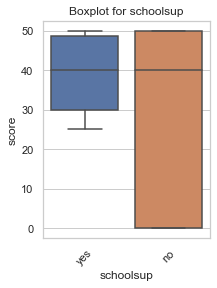

no


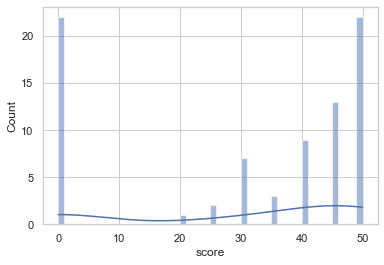

yes


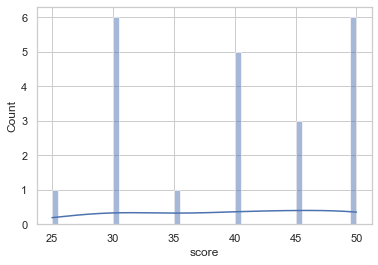


 Графики для paid


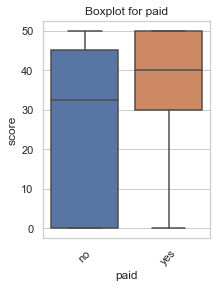

no


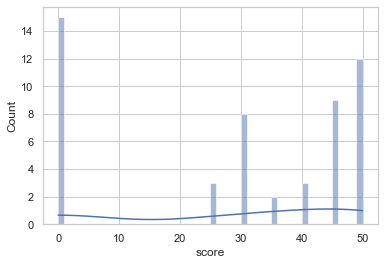

yes


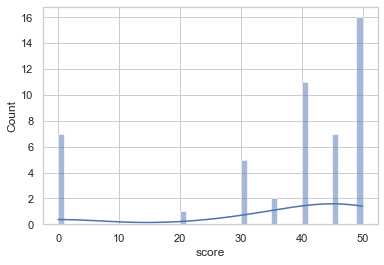


 Графики для romantic


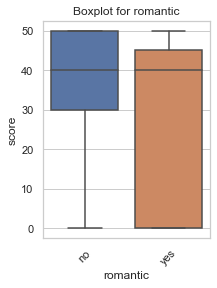

no


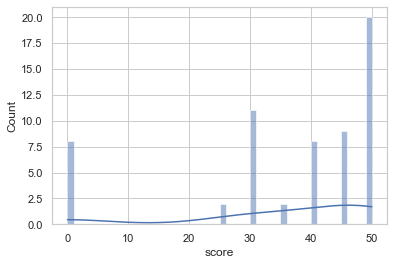

yes


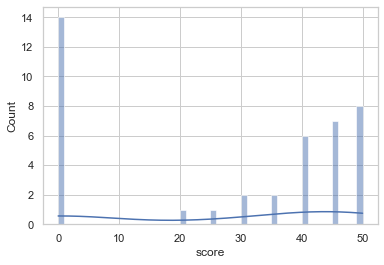

In [82]:
score_nominative(stud_f)

Вывод: значимых числовых характеристик для score как в группах 1-2 (с разделением по гендерному признаку), так и в дф в целом - нет. Условно можно выделить характеристики, показывающие наибольшие результаты - absences, failures. Среди номинативных характеристик, для групп 1-2 значимыми характеристиками получились - paid, romantic, Fedu, higher, schoolsup. Для дф в целом, помимо romantic и higher, значимыми характеристиками оказались - address, Medu, Mjob. Предположительно, все указанные характеристики в дальнейшем можно будет использовать для прогнозирования результатов экзамена.